### Tutorial - Introduction to scRNA-seq analysis using Scanpy
This Tutorial was guided heavily by Malte Luecken's "Best Practices" Notebook. (PostDoc from TheisLab) <br>
The original notebook can be found at https://github.com/theislab/single-cell-tutorial/blob/master/latest_notebook/Case-study_Mouse-intestinal-epithelium_1906.ipynb

It is highly recommended to look at the Scanpy Documentation to see a more detailed explanation on the function and other parameters one can specifiy: <br>
https://scanpy.readthedocs.io/en/stable/  

### Webtool to Longitudinal single cell transcriptomics:
https://theislab.github.io/LungInjuryRegeneration/
### Webtool to IPF Cell Atlas:
http://www.ipfcellatlas.com/

In [1]:
## Import Libraries used in this script
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb

import warnings
warnings.filterwarnings("ignore")

## Define a nice colour map for gene expression
from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("", ["lightgray", "red", "darkred"], N = 128)

sc.settings.figdir = "Plots/"
sc.set_figure_params(vector_friendly = True)
plt.rcParams.update({"font.size": 14})
sb.set_style("ticks")

sc.logging.print_version_and_date()

Running Scanpy 1.8.1, on 2021-12-07 12:58.


In [2]:
adata = sc.read("Data/Aging_Tutorial.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 6834 × 16959
    obs: 'batch', 'age', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'leiden_1', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'cell_type_automated_colors', 'cell_type_colors', 'cell_type_final_colors', 'dendrogram_leiden_1', 'grouping_colors', 'hvg', 'identifier_colors', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'leiden_4_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
adata.obs.head()

batch  age identifier  n_counts  n_genes  percent_mito  \
index                                                                   
CGGTCACACCCG-0  good  24m    muc3838    3830.0      437      0.010960   
CGAAAACAGTCC-0  good  24m    muc3838    3739.0      522      0.017638   
TTGTAGAGATTG-0  good  24m    muc3838    3822.0     1217      0.020131   
TGCGAGTCTTCT-0  good  24m    muc3838    3658.0     1446      0.011752   
TCCTGCTCCCTT-0  good  24m    muc3838    3405.0     1583      0.012335   

               leiden_1   cell_type  
index                                
CGGTCACACCCG-0       16  Club cells  
CGAAAACAGTCC-0       16  Club cells  
TTGTAGAGATTG-0       13  Club cells  
TGCGAGTCTTCT-0       13  Club cells  
TCCTGCTCCCTT-0       13  Club cells

In [5]:
adata.obs.cell_type.value_counts()

AT2 cells                      2193
Cd4+ T cells                    740
Alveolar macrophage             685
Club cells                      451
B cells                         446
Ciliated cells                  443
vascular endothelial cells      372
Dendritic cells                 360
Monocytes                       349
Interstitial macrophages        265
CD8+ T cells                    132
Fibroblasts                     112
Mesothelial cells                95
Capillary endothelial cells      90
Neutrophils                      80
Plasma cells                     21
Name: cell_type, dtype: int64

In [6]:
## See the first 10 gene names
print(adata.var_names[0:10])

## Show the first 10 cell ids
print(adata.obs_names[0:10])

## Show the expression values of the first 10 genes in the first 5 cells
## adata objects store the expression matrix in .X layer (cells (rows) x genes (columns))
adata.X[0:5, 0:10]

Index(['0610005C13Rik', '0610007N19Rik', '0610007P14Rik', '0610009B22Rik',
       '0610009D07Rik', '0610009E02Rik', '0610009L18Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik'],
      dtype='object', name='index')
Index(['CGGTCACACCCG-0', 'CGAAAACAGTCC-0', 'TTGTAGAGATTG-0', 'TGCGAGTCTTCT-0',
       'TCCTGCTCCCTT-0', 'TCCTGCTCCCTG-0', 'GACATCTCGCCA-0', 'TCCTGCTCCCTC-0',
       'GCACTTTAGAAT-0', 'CCCGCTTCTACG-0'],
      dtype='object', name='index')


<5x10 sparse matrix of type '<class 'numpy.float32'>'
	with 4 stored elements in Compressed Sparse Row format>

In [7]:
## Show cell type numbers split by age
pd.crosstab(adata.obs.age, adata.obs.cell_type)

cell_type  AT2 cells  Alveolar macrophage  B cells  CD8+ T cells  \
age                                                                
3m              1392                  473       11            11   
24m              801                  212      435           121   

cell_type  Capillary endothelial cells  Cd4+ T cells  Ciliated cells  \
age                                                                    
3m                                  26            33             124   
24m                                 64           707             319   

cell_type  Club cells  Dendritic cells  Fibroblasts  Interstitial macrophages  \
age                                                                             
3m                335              131           29                        48   
24m               116              229           83                       217   

cell_type  Mesothelial cells  Monocytes  Neutrophils  Plasma cells  \
age                                                                  
3m                        33         23            6             4   
24m                       62        326           74            17   

cell_type  vascular endothelial cells  
age                                    
3m                                 79  
24m                               293

### Plot QC Metrics
Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

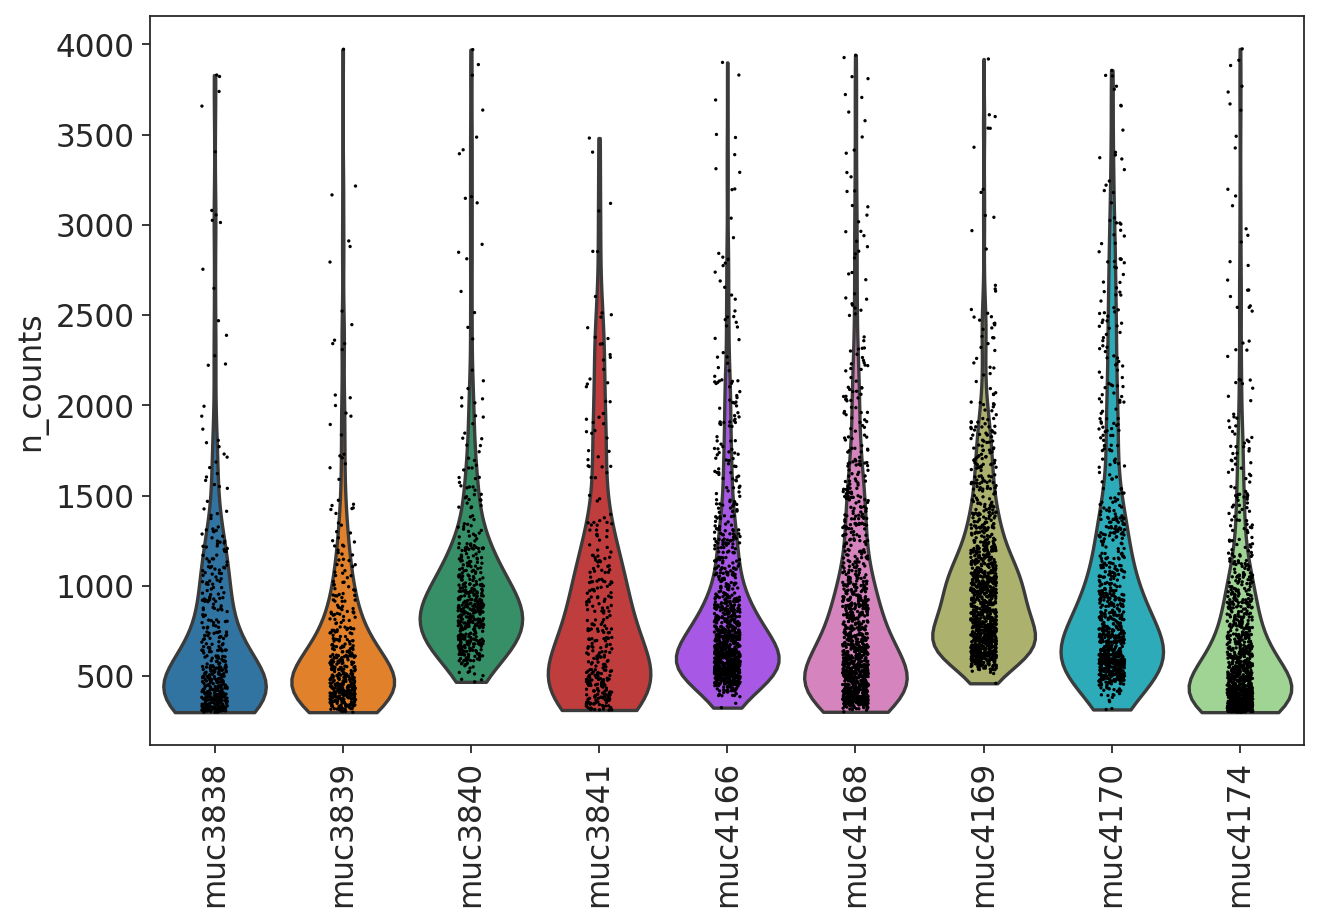

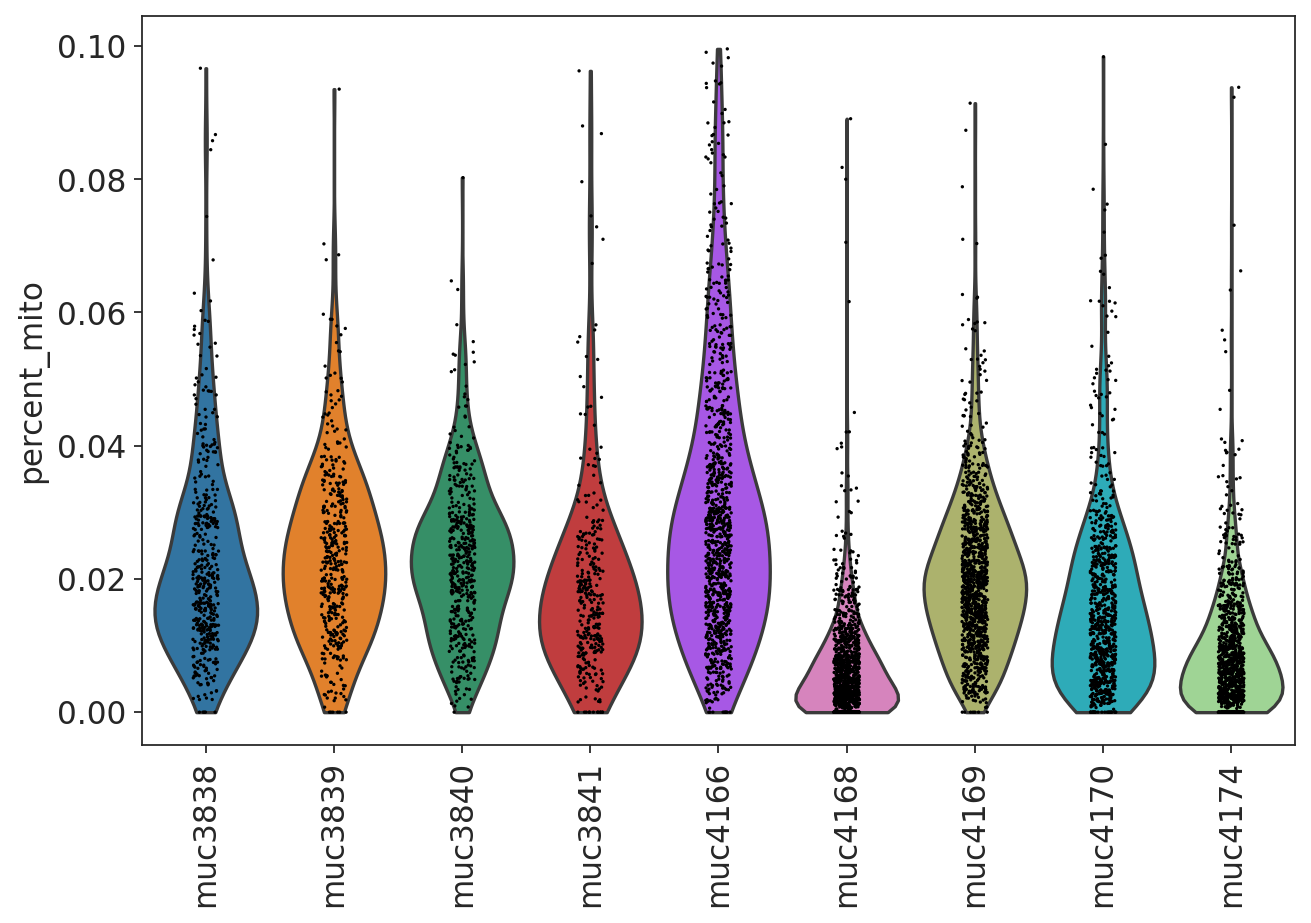

In [8]:
plt.rcParams['figure.figsize'] = (8, 6)
sc.pl.violin(adata, "n_counts", groupby = "identifier", size = 1.5, rotation = 90)
sc.pl.violin(adata, "percent_mito", groupby = "identifier", size = 1.5, rotation = 90)

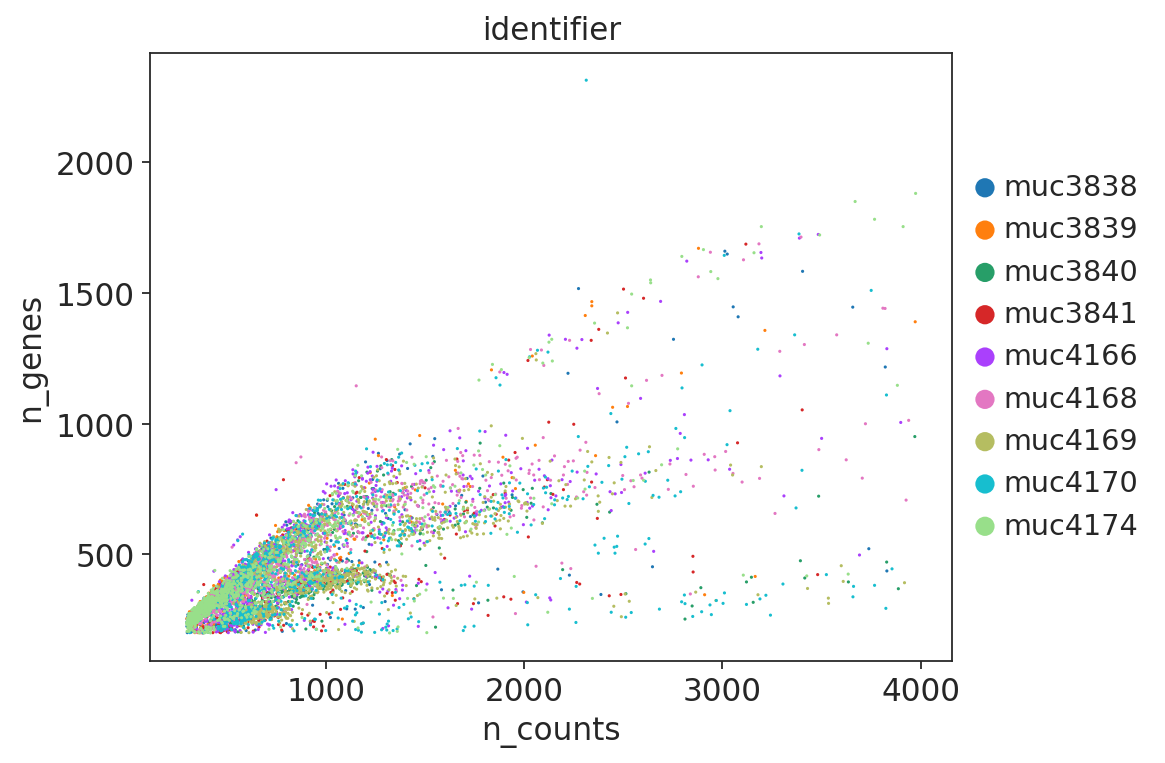

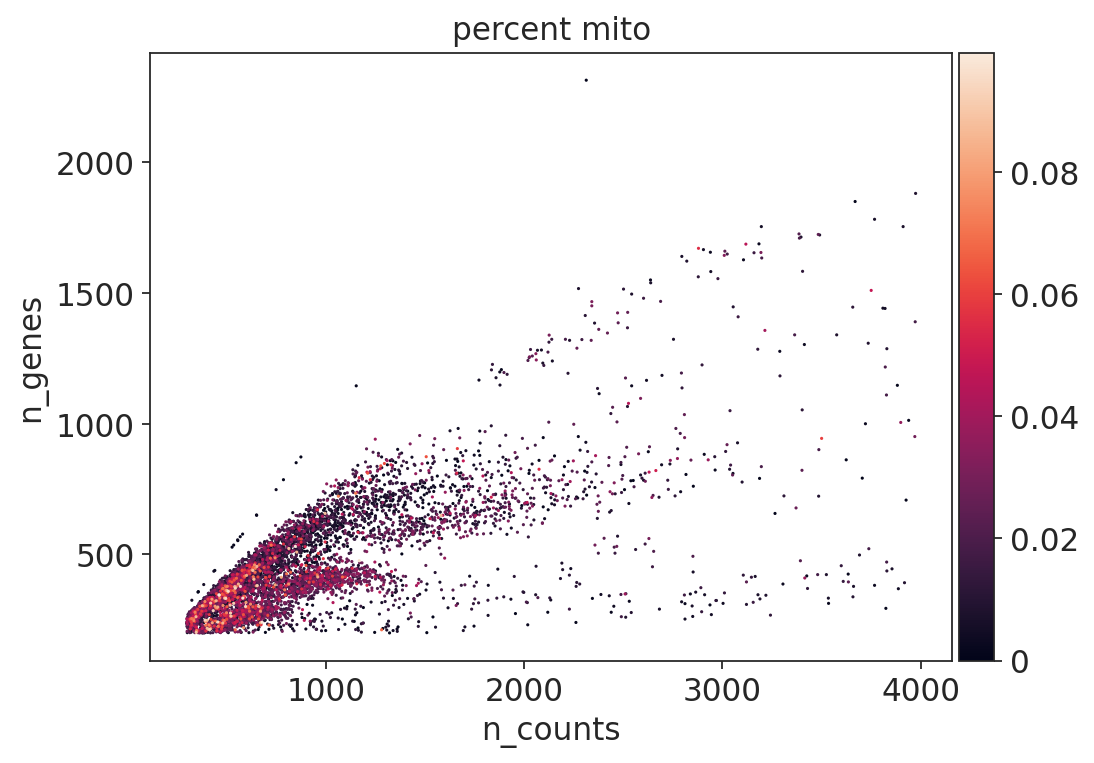

In [10]:
#Data quality summary plots
plt.rcParams['figure.figsize'] = (6, 5)

sc.pl.scatter(adata, "n_counts", "n_genes", color = "identifier", size = 8)

## Zoom in to range
sc.pl.scatter(adata[adata.obs["n_counts"] < 8000],"n_counts","n_genes", color = "percent_mito", size = 8)

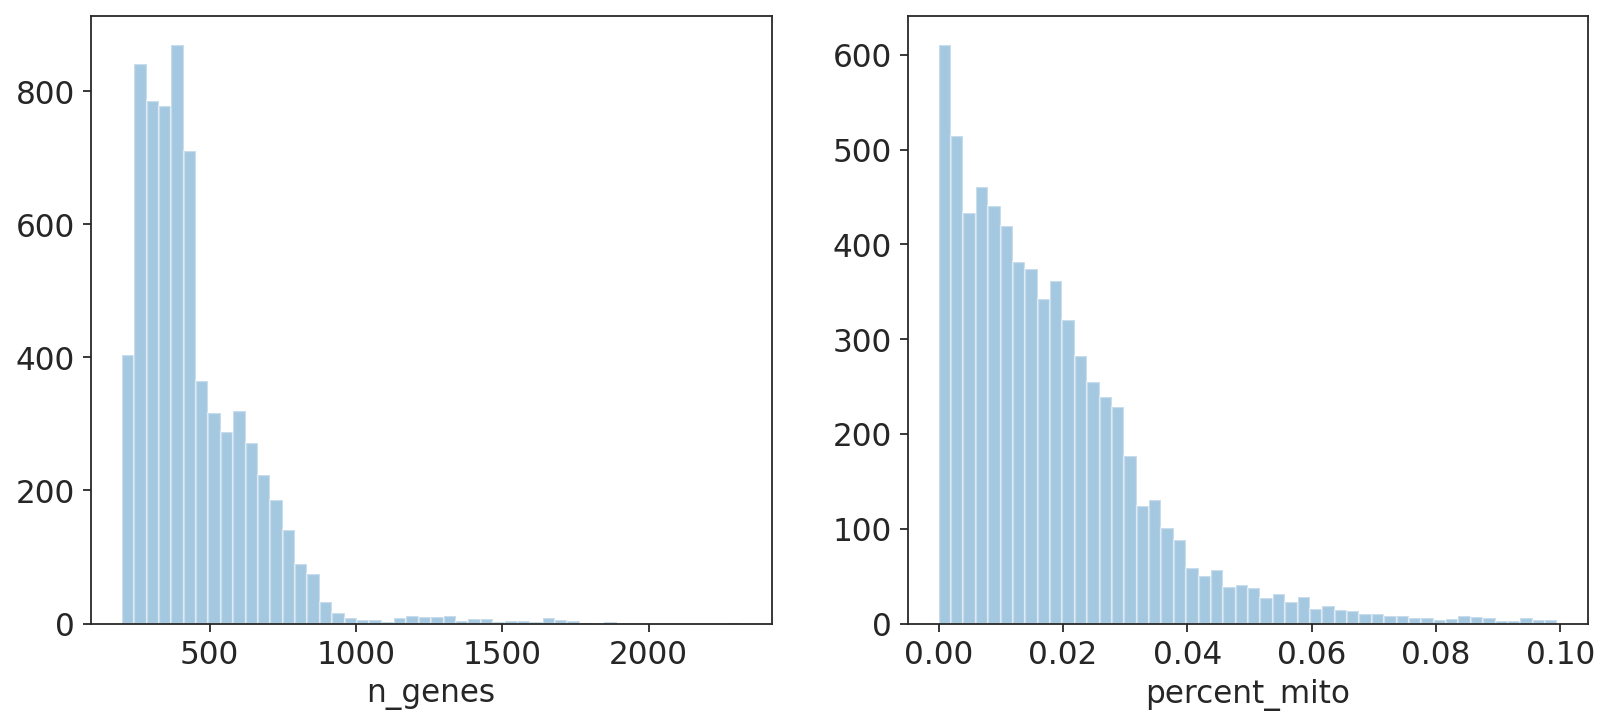

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axs = axs.ravel()
sb.distplot(adata.obs["n_genes"], kde = False, ax = axs[0])
sb.distplot(adata.obs["percent_mito"], kde = False, ax = axs[1])
plt.show()

#### Normalized and log transformed counts are stored in adata.X 
These values are used in all of the visualisazions later on, e.g. UMAP, dotplot... 

In [12]:
print("processed Counts in X\n", adata.X[0:5, 100:110].todense())

processed Counts in X
 [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.17105123 0.         0.         0.17105123
  0.         0.17105123 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.3291818  0.         0.        ]
 [0.         0.         0.19012266 0.         0.         0.
  0.         0.         0.         0.        ]]


### In this object, the Principal components, k-nearest neighbor graph and UMAP are already calculated
See entries "X_pca" and "X_umap" in obsm

In [13]:
adata

AnnData object with n_obs × n_vars = 6834 × 16959
    obs: 'batch', 'age', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'leiden_1', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'cell_type_automated_colors', 'cell_type_colors', 'cell_type_final_colors', 'dendrogram_leiden_1', 'grouping_colors', 'hvg', 'identifier_colors', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'leiden_4_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### UMAP as lower-dimensional representation of the data set
Captures the global structure of the high dimensional data set, each dot represents a single cell which can be coloured by any annotation you have stored in adata.obs

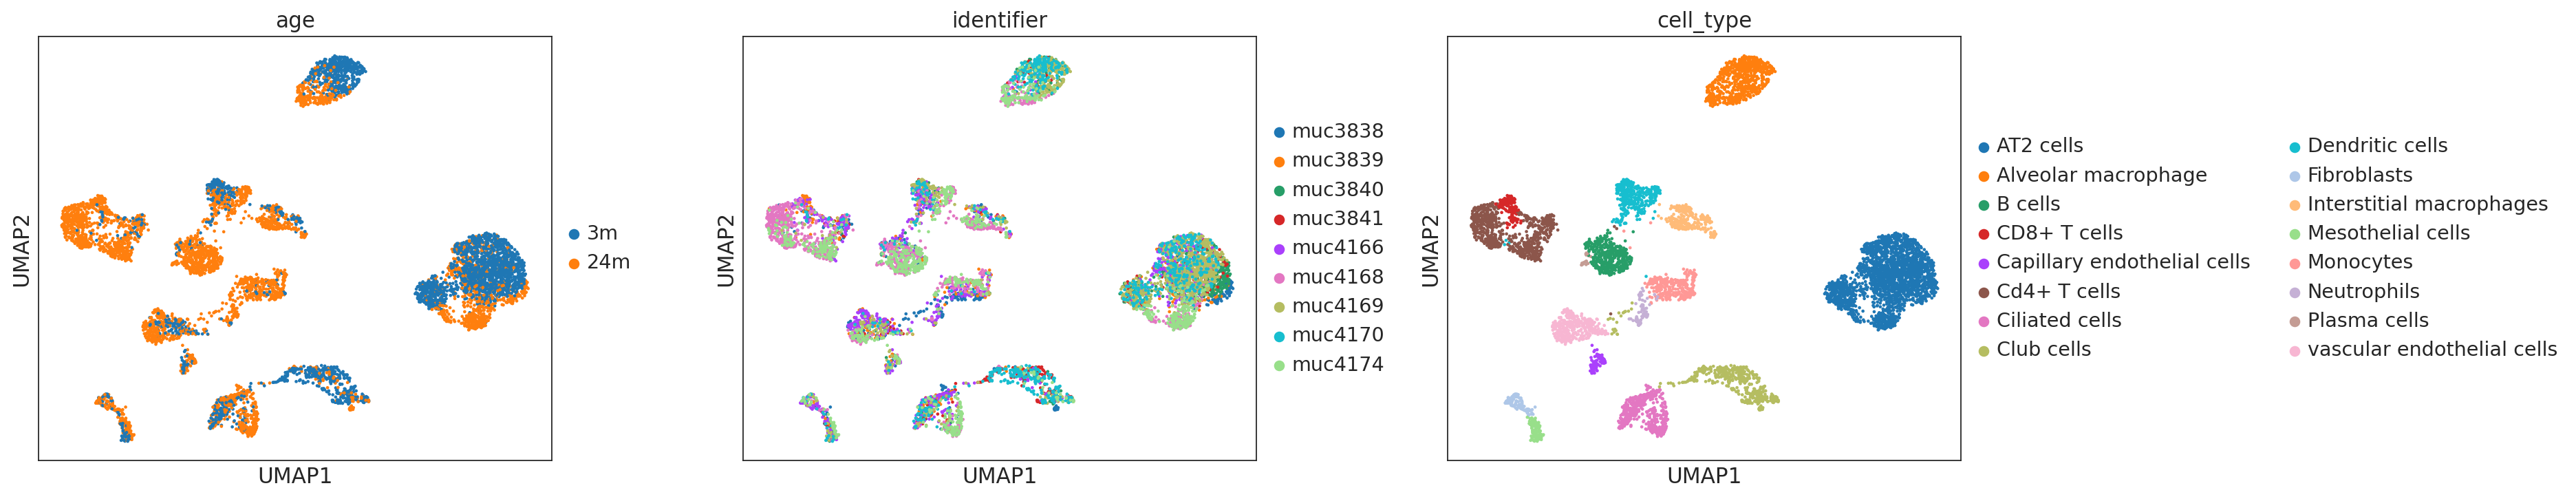

In [14]:
sc.pl.umap(adata, color = ["age", "identifier", "cell_type"], wspace = 0.25)

#### You can also overlay the labels onto the embedding

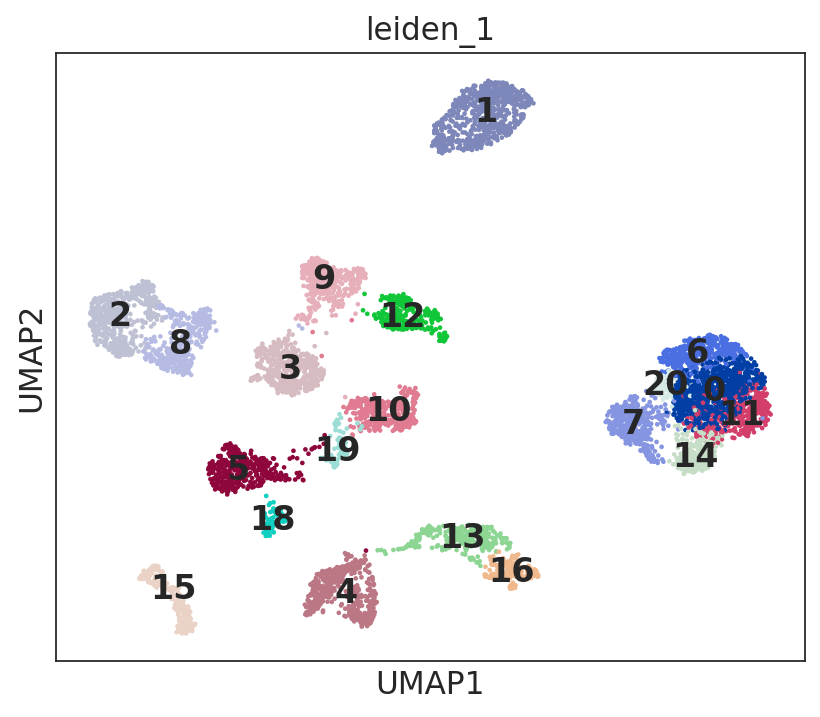

In [15]:
sc.pl.umap(adata, color = ["leiden_1"], legend_loc = "on data", legend_fontsize = 15)

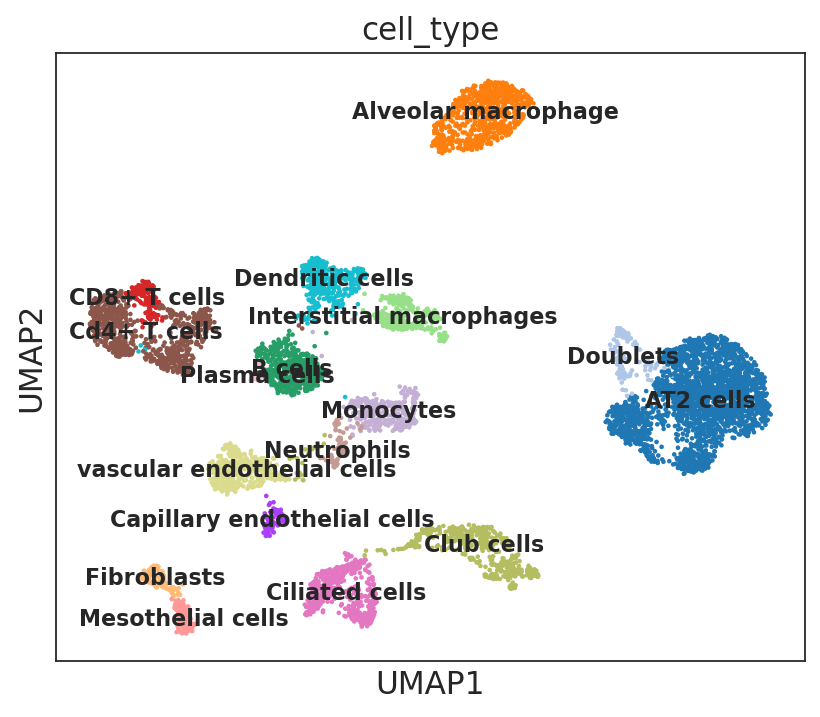

In [16]:
sc.pl.umap(adata, color = ["cell_type"], legend_loc = "on data", legend_fontsize = 10)

### Save Plots
You can save the plot by specifying the save Parameter

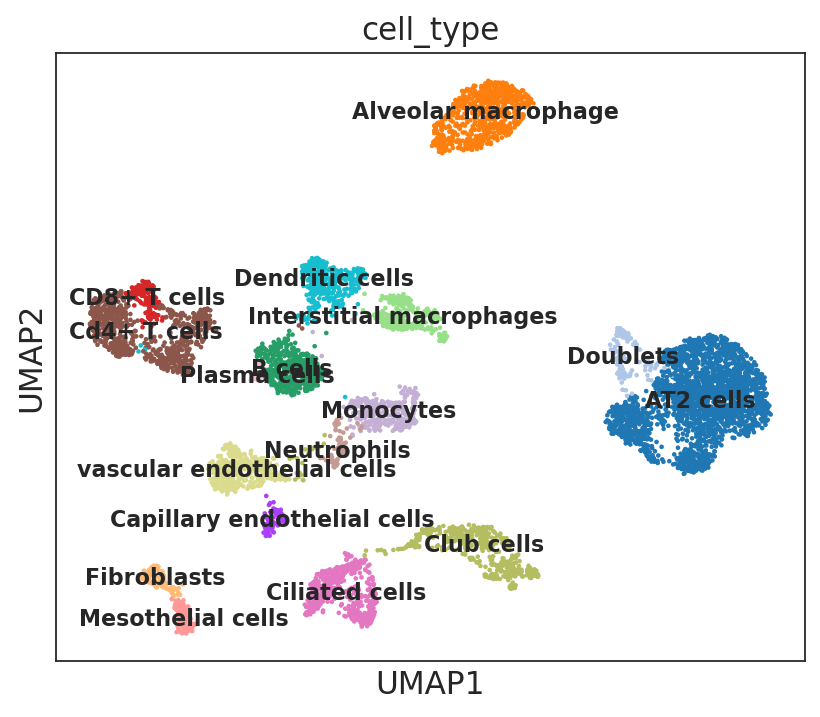

In [17]:
sc.pl.umap(adata, color = ["cell_type"], legend_loc = "on data", legend_fontsize = 10, save = "_celltype.pdf")

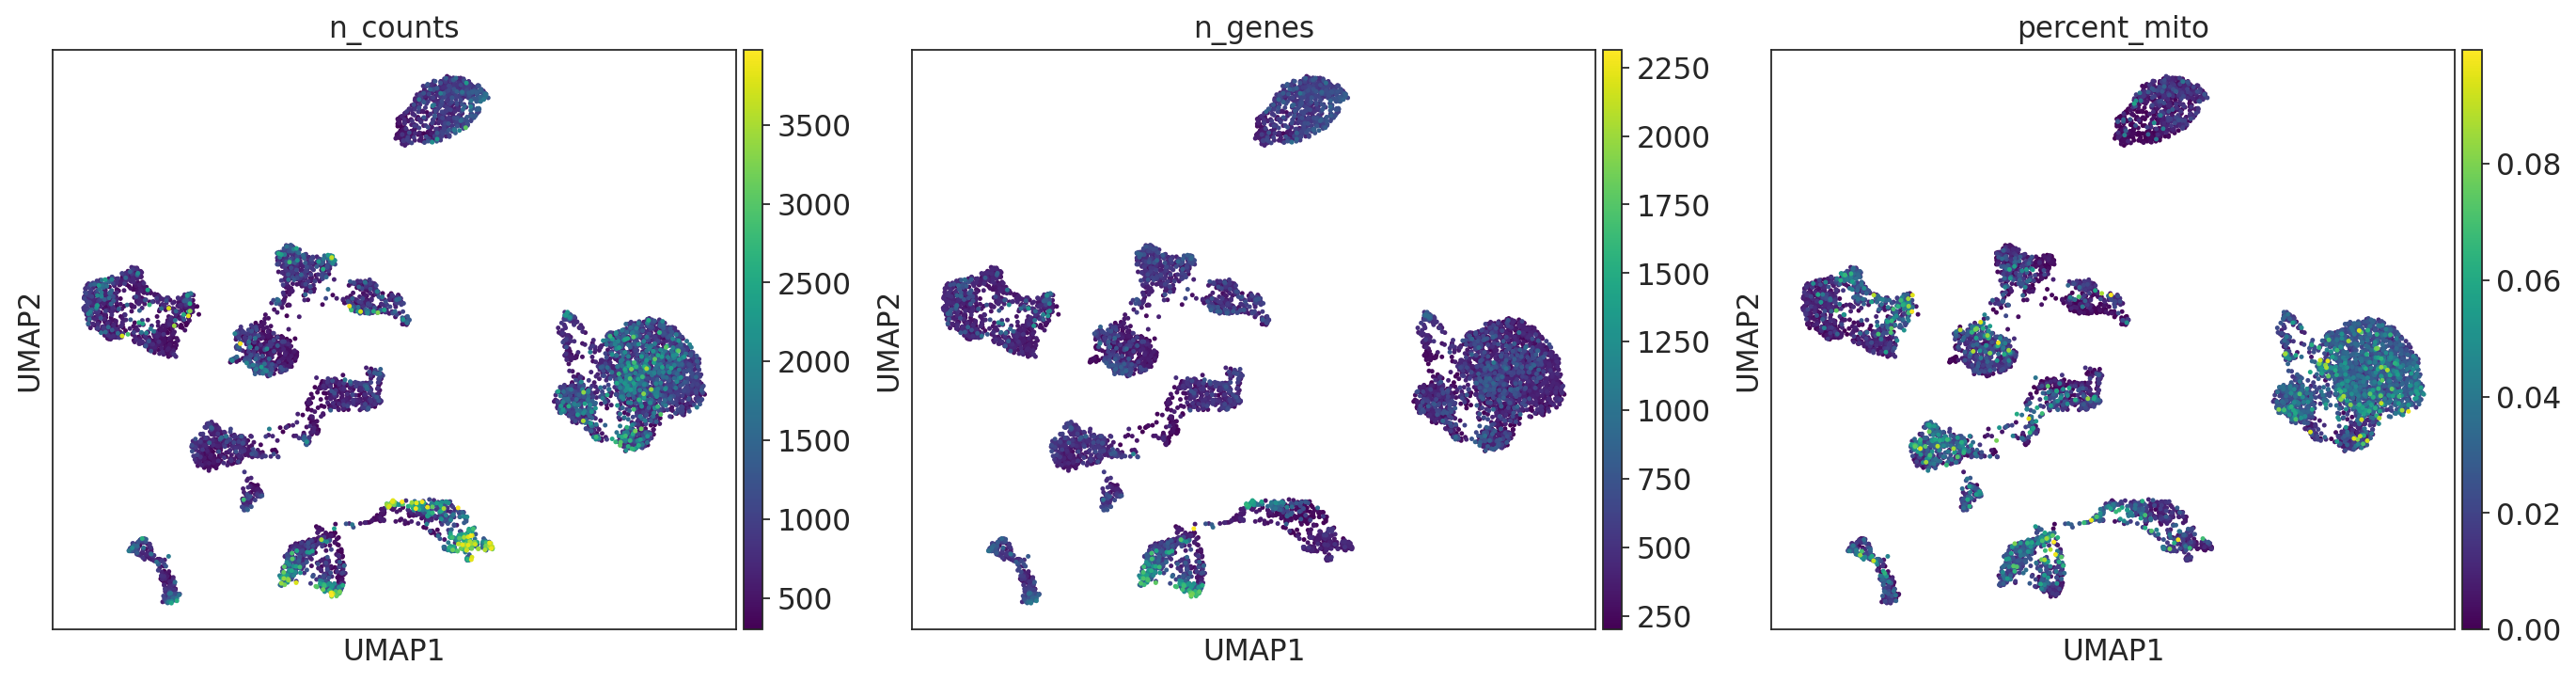

In [18]:
sc.pl.umap(adata, color = ["n_counts", "n_genes", "percent_mito"], size = 20, cmap = "viridis")

#### and show gene expression Feature plots by giving gene names in the color paramter

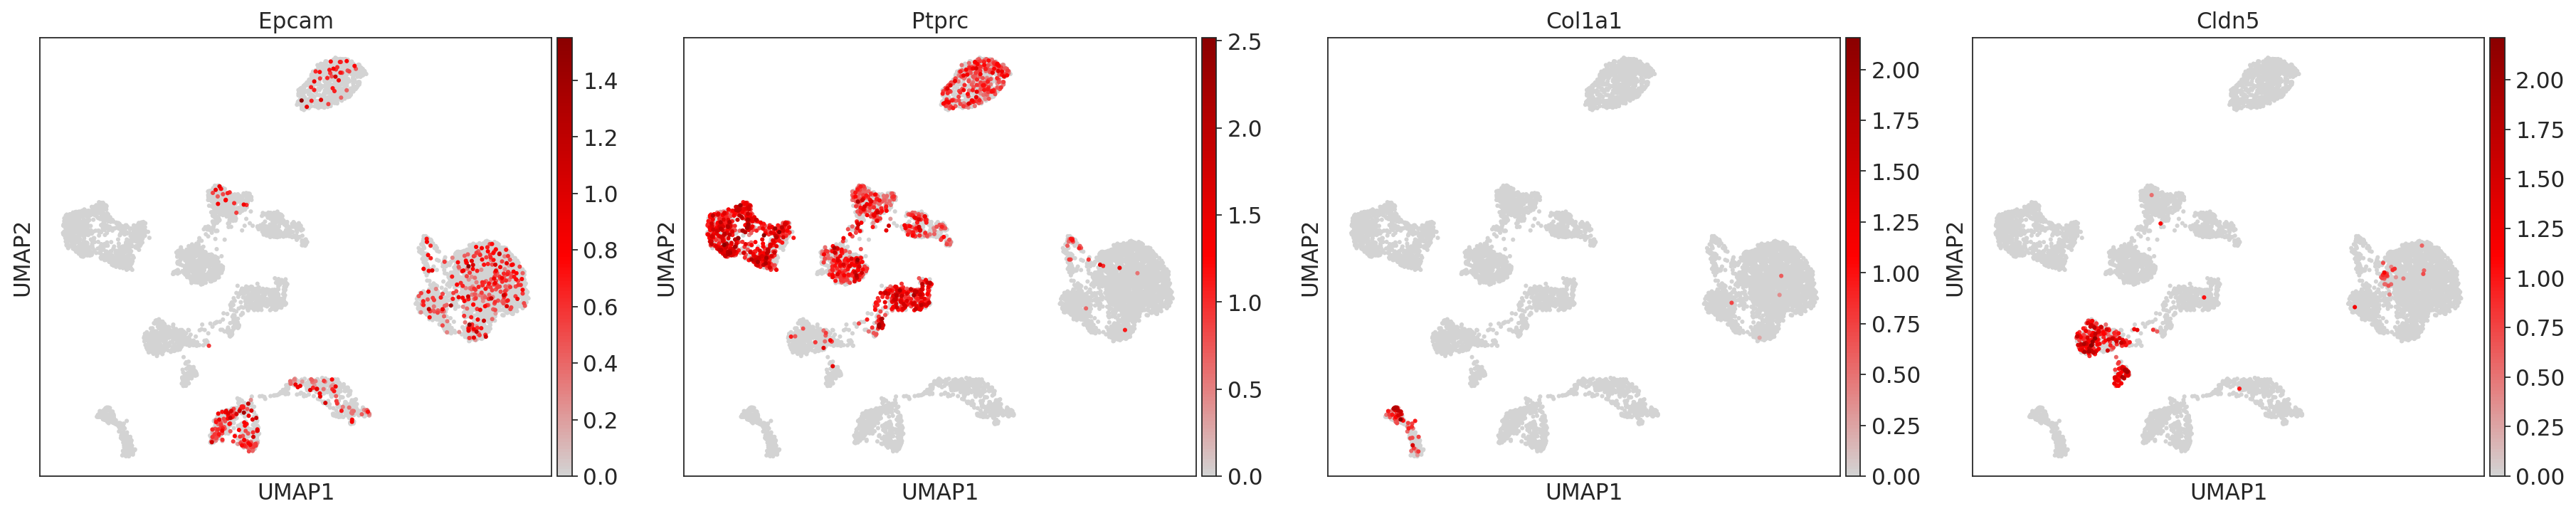

In [19]:
sc.pl.umap(adata, color = ["Epcam", "Ptprc", "Col1a1", "Cldn5"], cmap = gray_red, size = 30)

#### Highlight certain labels by specifying them with groups

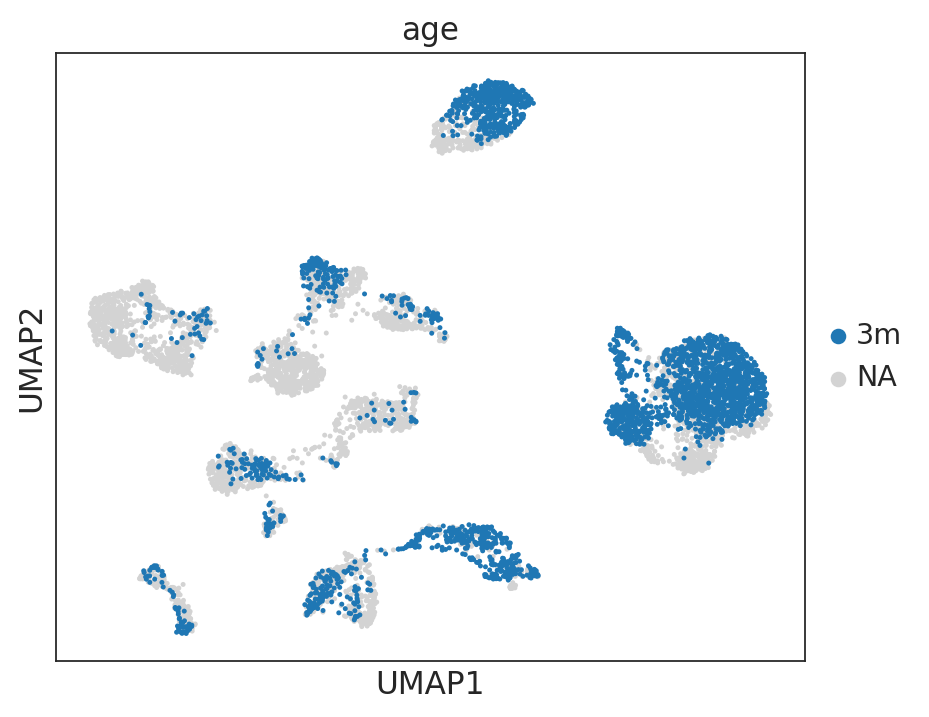

In [20]:
sc.pl.umap(adata, color = ["age"], groups = ["3m"], size = 20)

#### and show only cells from young mice, and colour them by cell type or expression

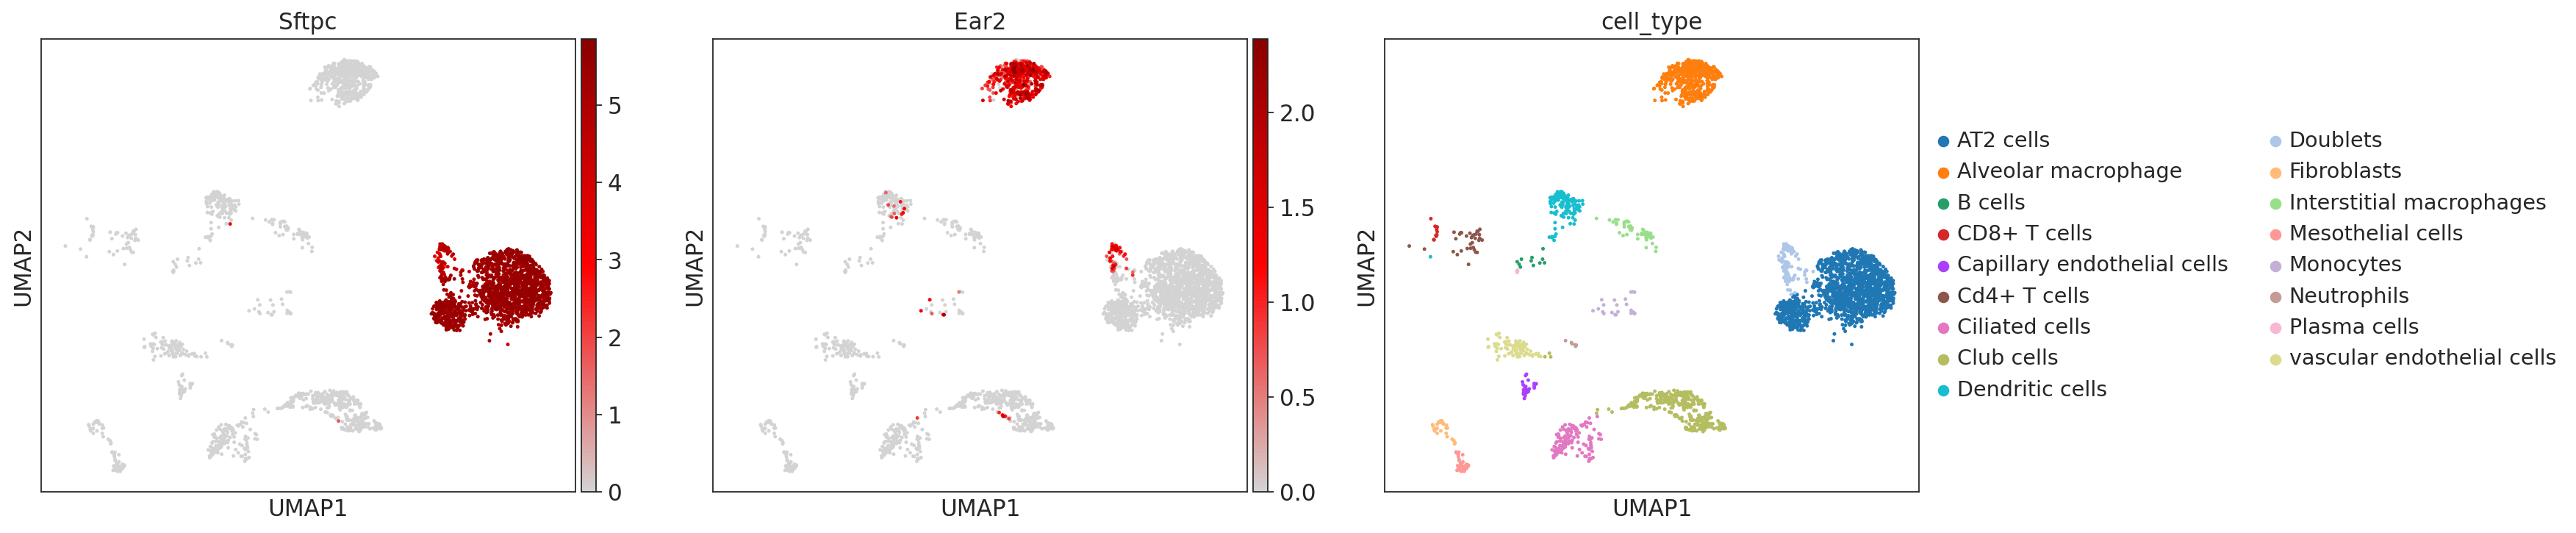

In [21]:
cells = adata.obs.age == "3m"
sc.pl.umap(adata[cells], color = ["Sftpc", "Ear2", "cell_type"], cmap = gray_red, size = 20)

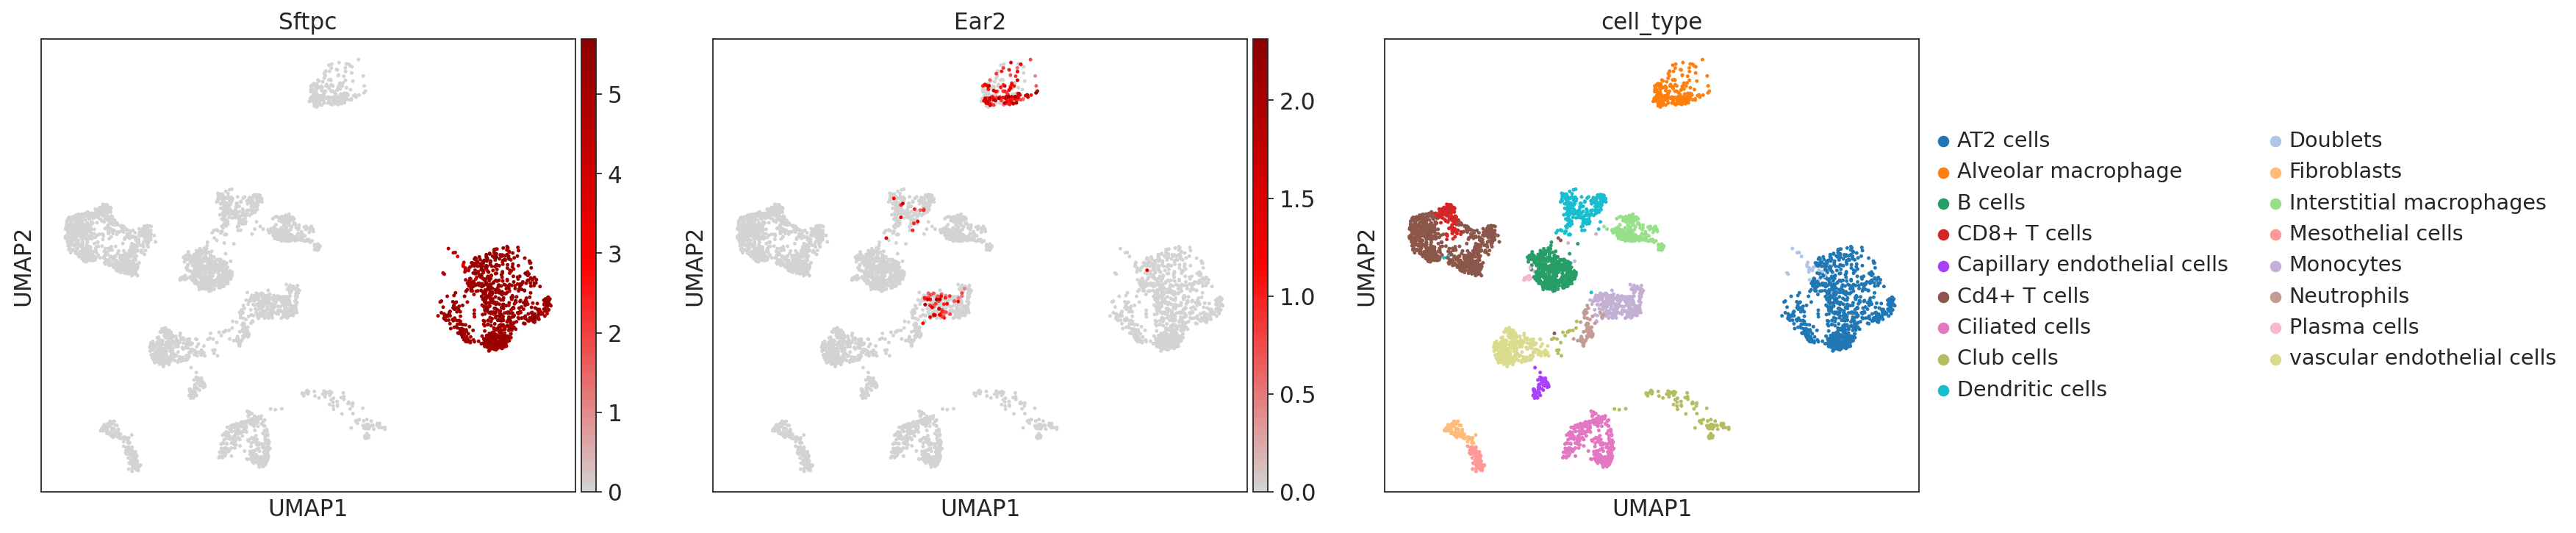

In [22]:
cells = adata.obs.age == "24m"
sc.pl.umap(adata[cells], color = ["Sftpc", "Ear2", "cell_type"], cmap = gray_red, size = 20)

### Differential Gene Expression - All Markers Table

In [23]:
## All Markers
sc.tl.rank_genes_groups(adata, groupby = 'cell_type', use_raw = False, n_genes = 500,
                        method = "wilcoxon", pts = True)

In [24]:
## Combine into one Data Frame (comparable to Marker Table)
result = adata.uns['rank_genes_groups']
allMarkers = []
for cluster in result['names'].dtype.names:
    current = pd.DataFrame({"gene": result["names"][cluster], "score": result["scores"][cluster],
                            "logfoldchange": result["logfoldchanges"][cluster], "pval": result["pvals"][cluster],
                            "pval_adj": result["pvals_adj"][cluster], 
                            "pct_within": result["pts"].loc[result["names"][cluster]][cluster],
                            "pct_outside": result["pts_rest"].loc[result["names"][cluster]][cluster],
                            "cluster": cluster})
    allMarkers.append(current)
allMarkers = pd.concat(allMarkers)
allMarkers.head()

gene      score  logfoldchange  pval  pval_adj  pct_within  \
index                                                                    
Sftpc      Sftpc  66.853851      10.321328   0.0       0.0    0.999088   
Sftpb      Sftpb  66.454201       7.613451   0.0       0.0    0.998632   
Sftpa1    Sftpa1  66.444931       8.098557   0.0       0.0    0.998632   
Sftpd      Sftpd  63.291592       6.583517   0.0       0.0    0.961240   
Slc34a2  Slc34a2  63.279949       7.022497   0.0       0.0    0.954856   

         pct_outside    cluster  
index                            
Sftpc       0.031315  AT2 cells  
Sftpb       0.041754  AT2 cells  
Sftpa1      0.044676  AT2 cells  
Sftpd       0.042589  AT2 cells  
Slc34a2     0.024008  AT2 cells

In [25]:
## Write to file
allMarkers.to_csv("Data/AllMarkers_cell_type.txt", sep = "\t", index = False)

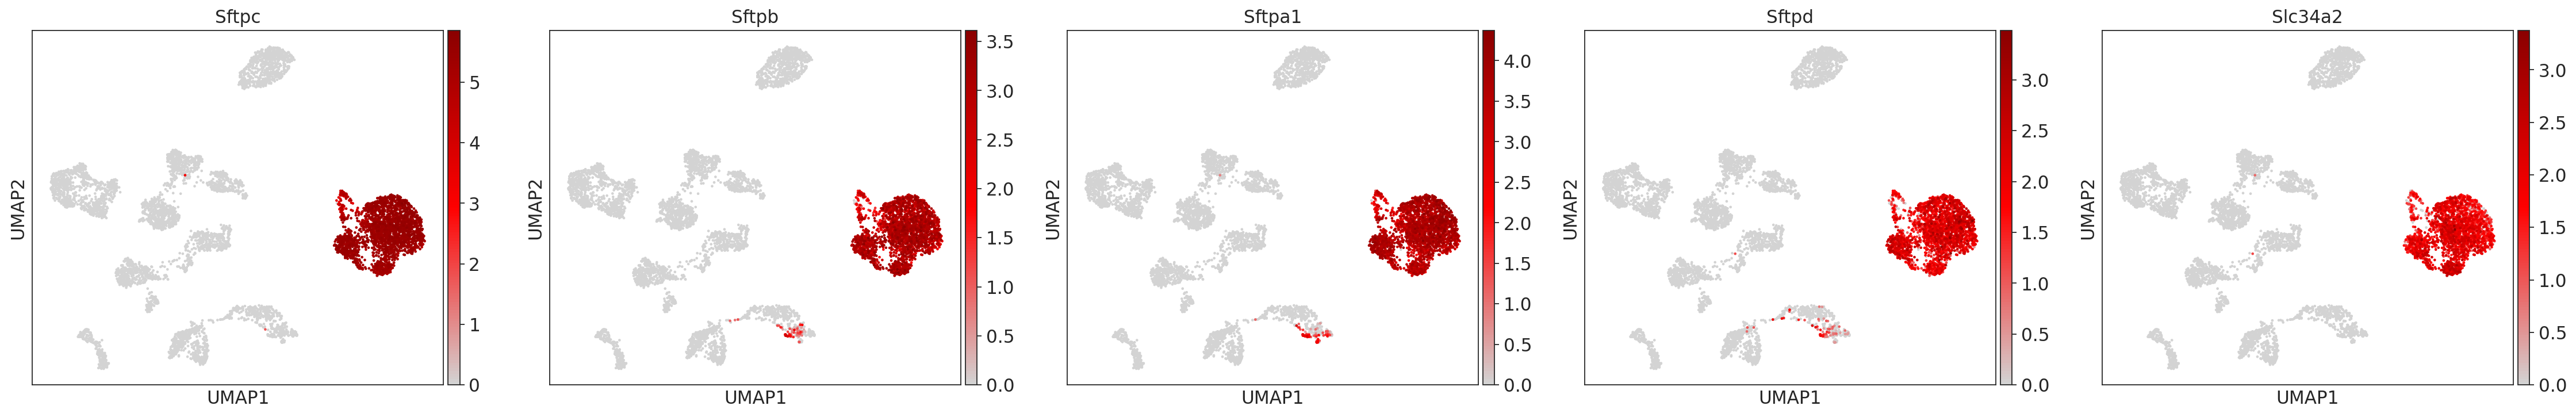

In [26]:
## Find top Genes for a Cluster
cluster = "AT2 cells"
genes = allMarkers.loc[allMarkers["cluster"] == cluster, "gene"].values

sc.pl.umap(adata, color = genes[0:5], ncols = 5, color_map = gray_red)

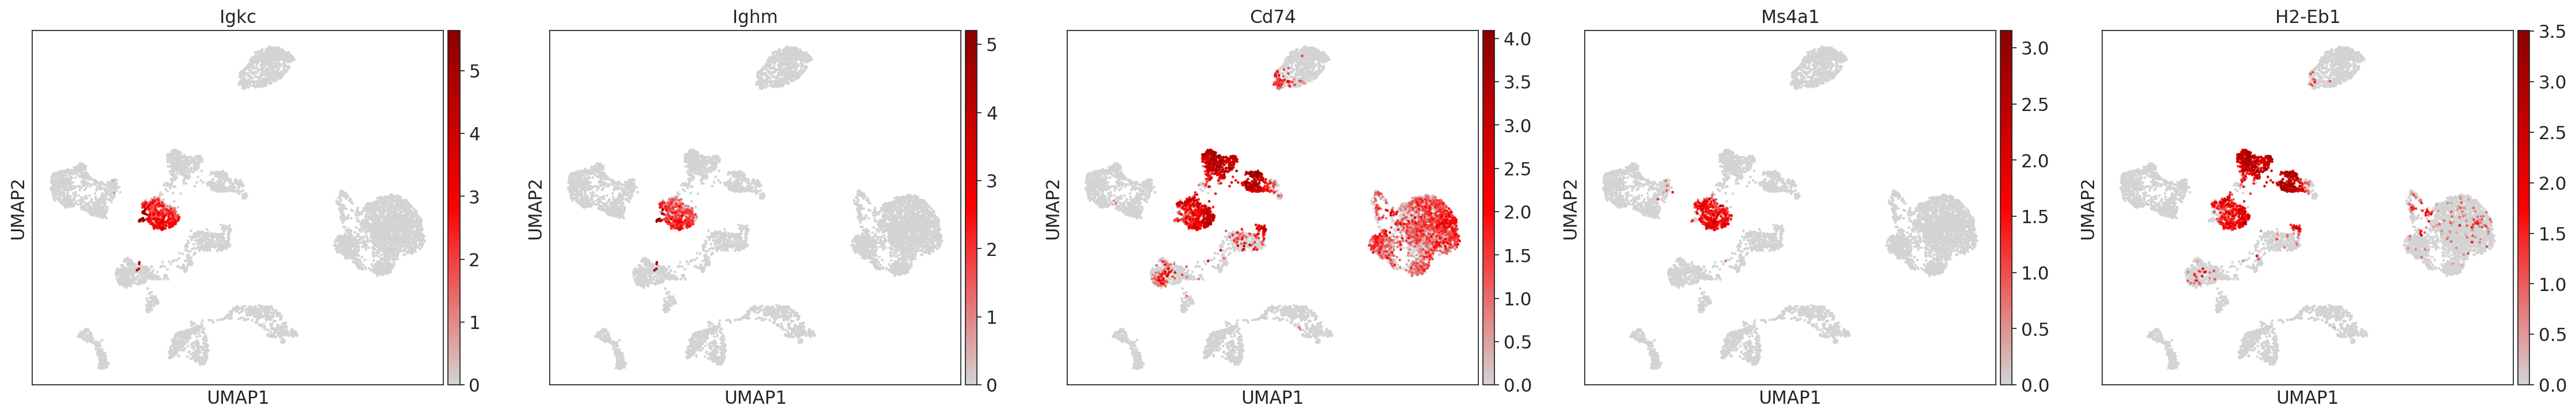

In [27]:
cluster = "B cells"
genes = allMarkers.loc[allMarkers["cluster"] == cluster, "gene"].values

sc.pl.umap(adata, color = genes[0:5], ncols = 5, color_map = gray_red)

### Marker Overview Plots

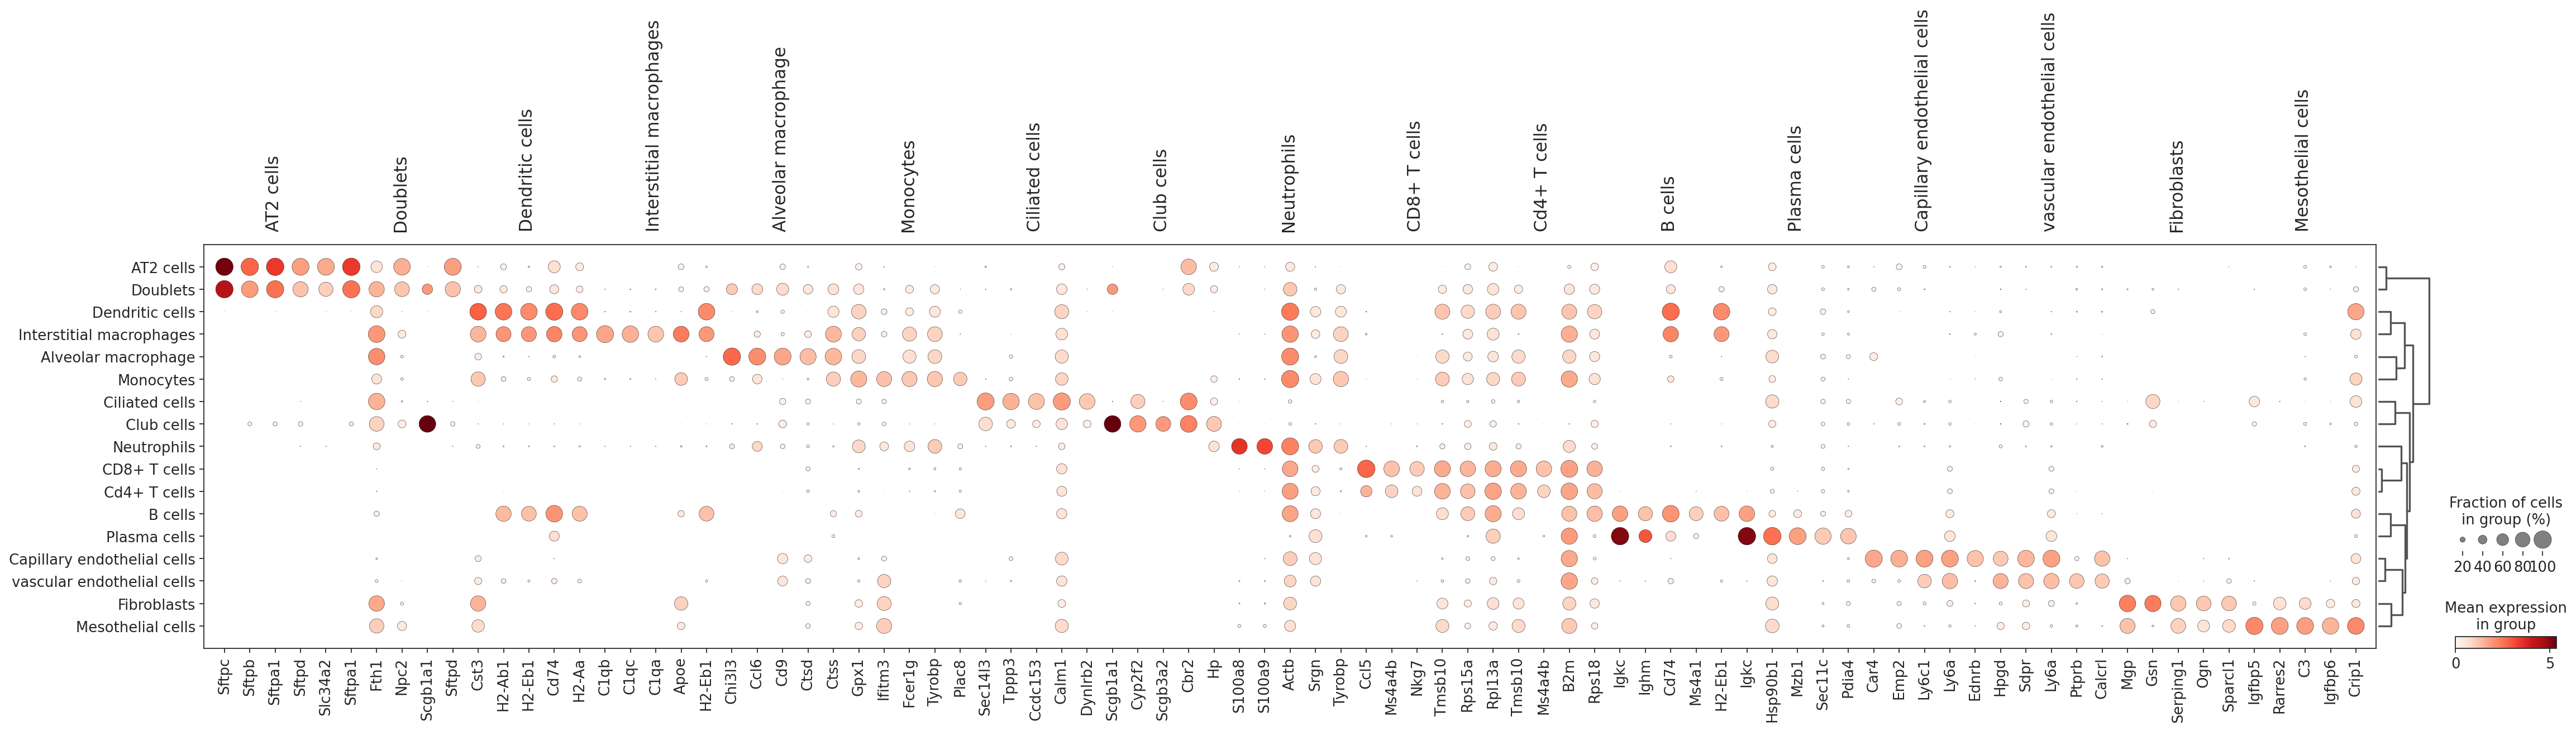

In [28]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes = 5)

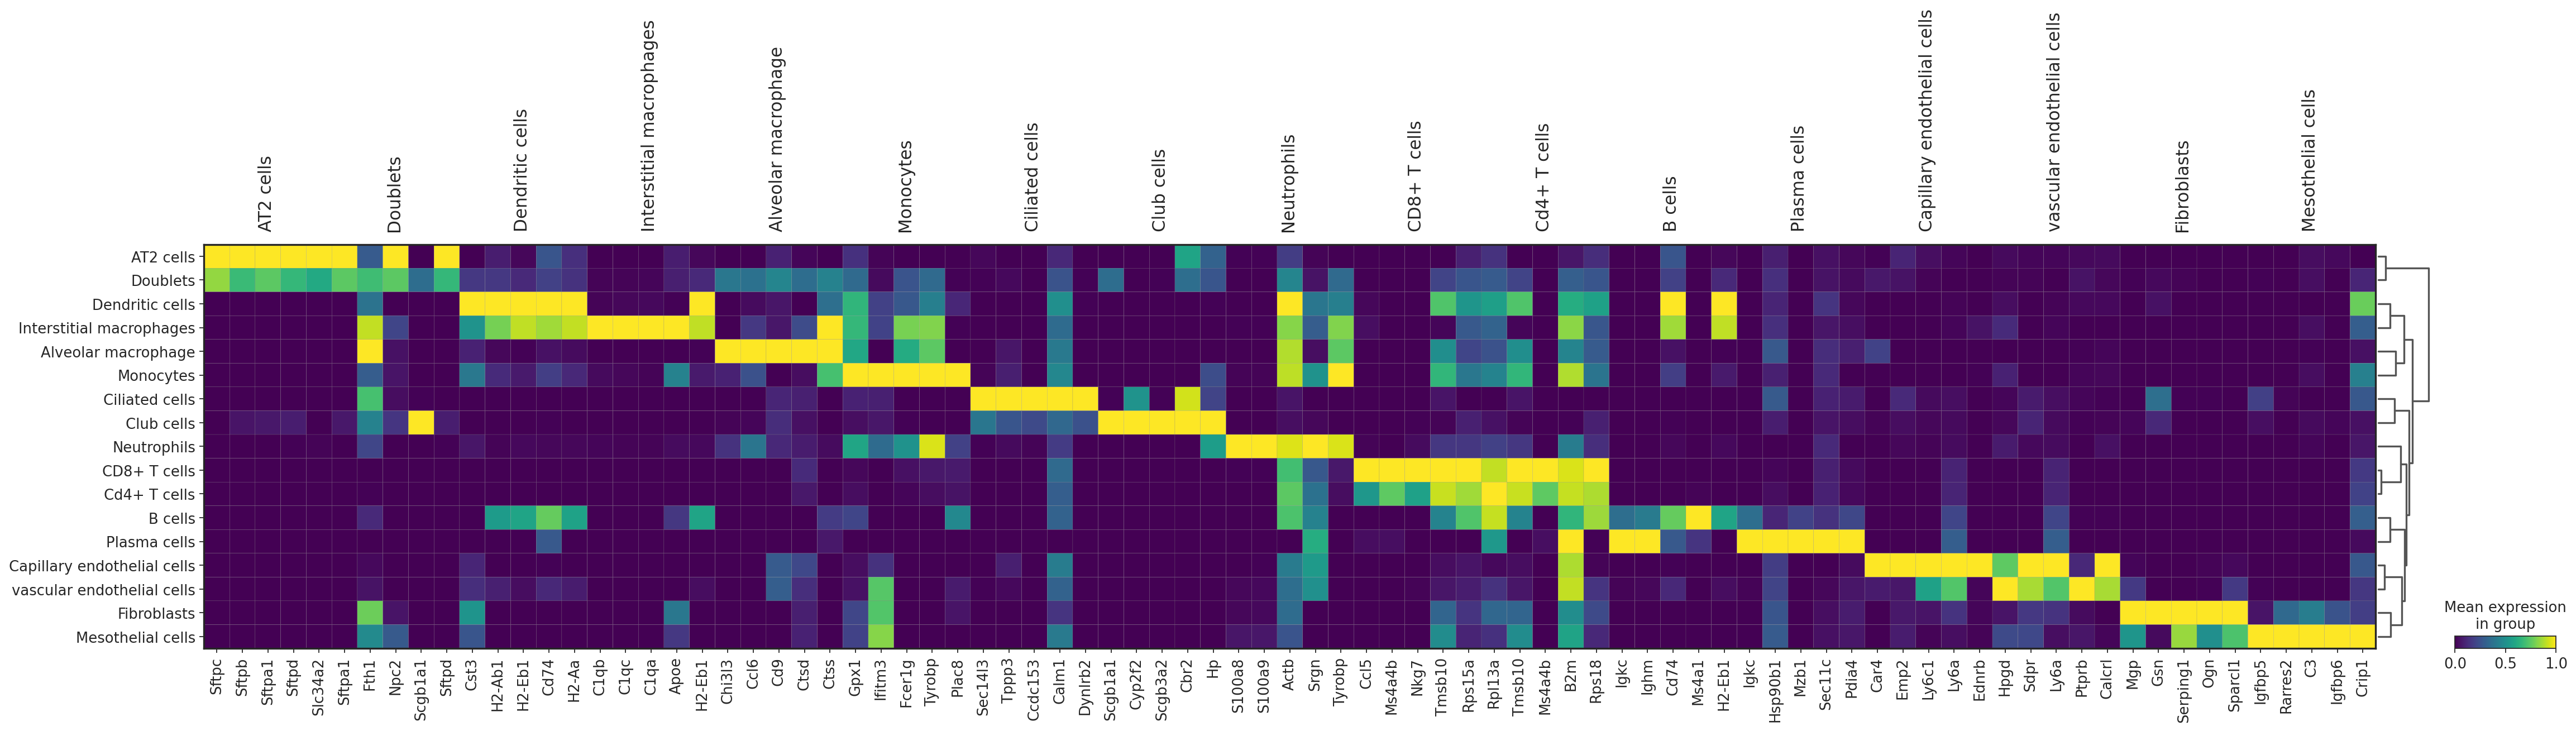

In [29]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes = 5, standard_scale = "var")

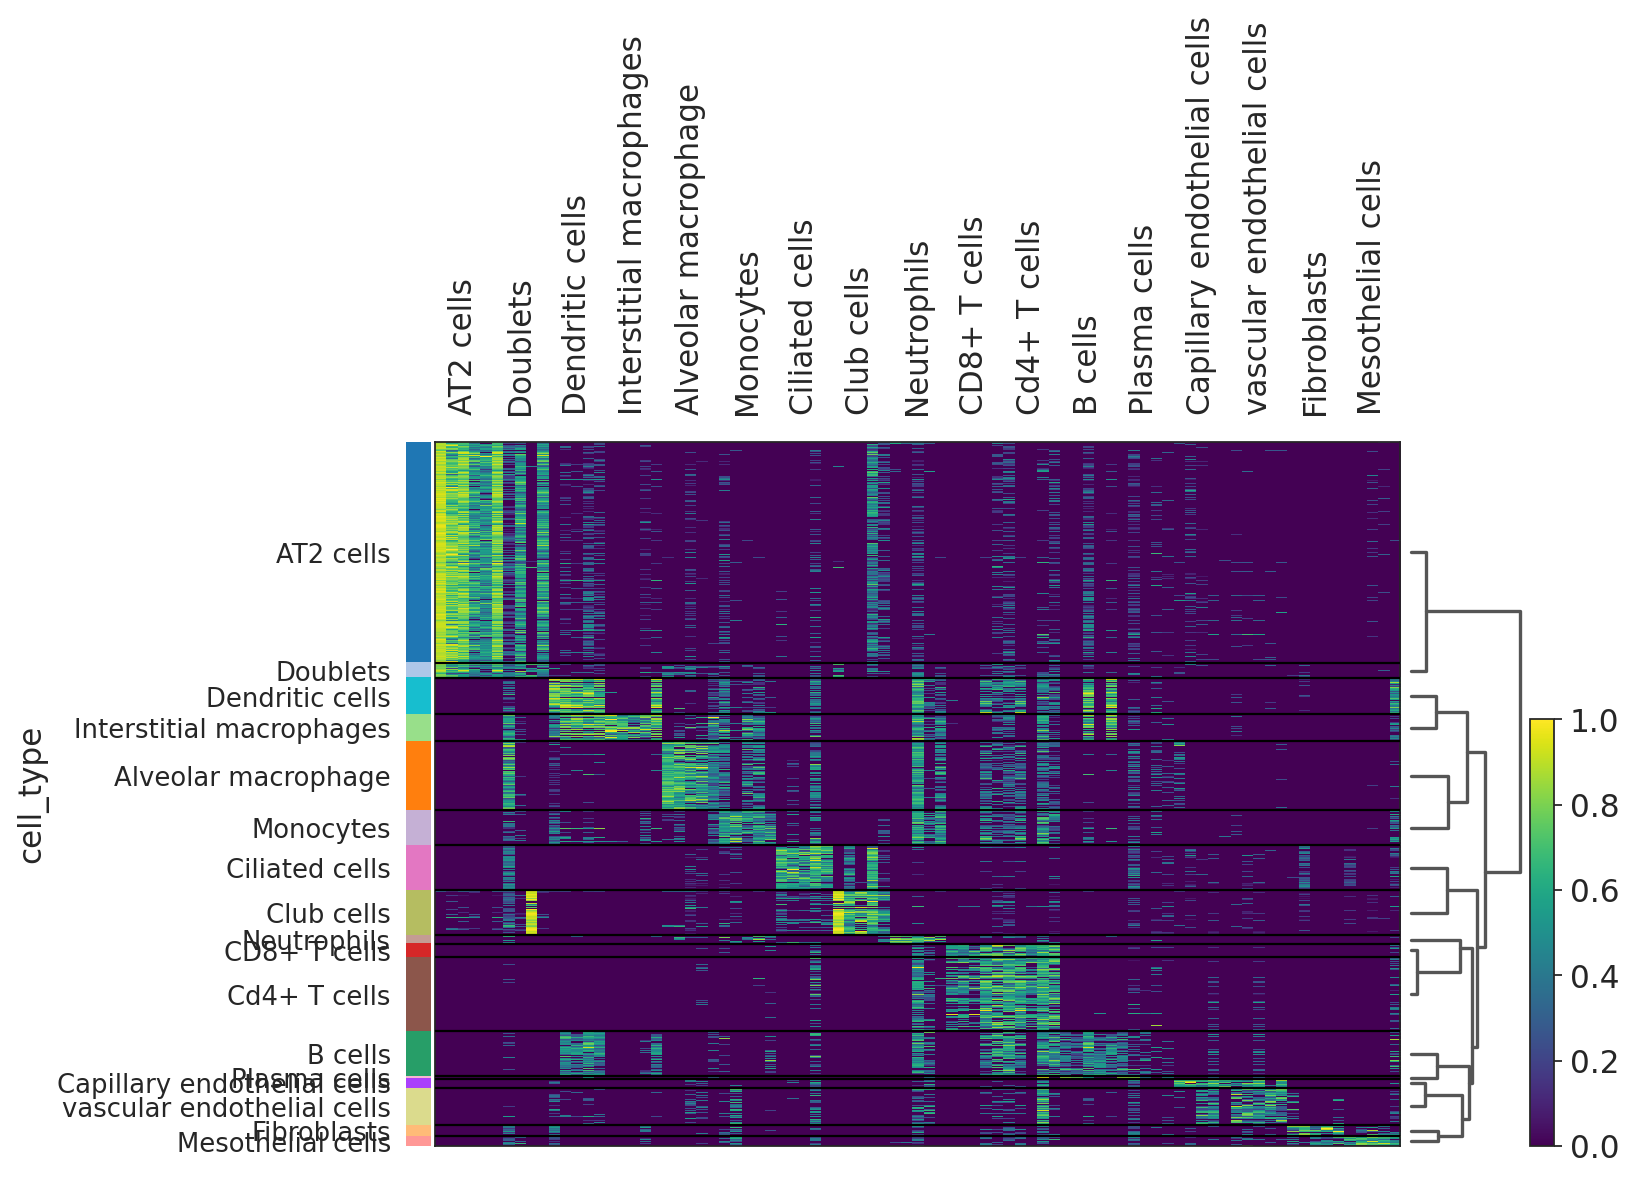

In [30]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes = 5, standard_scale = "var", cmap = "viridis")

### Specify genes by Parameter var_names

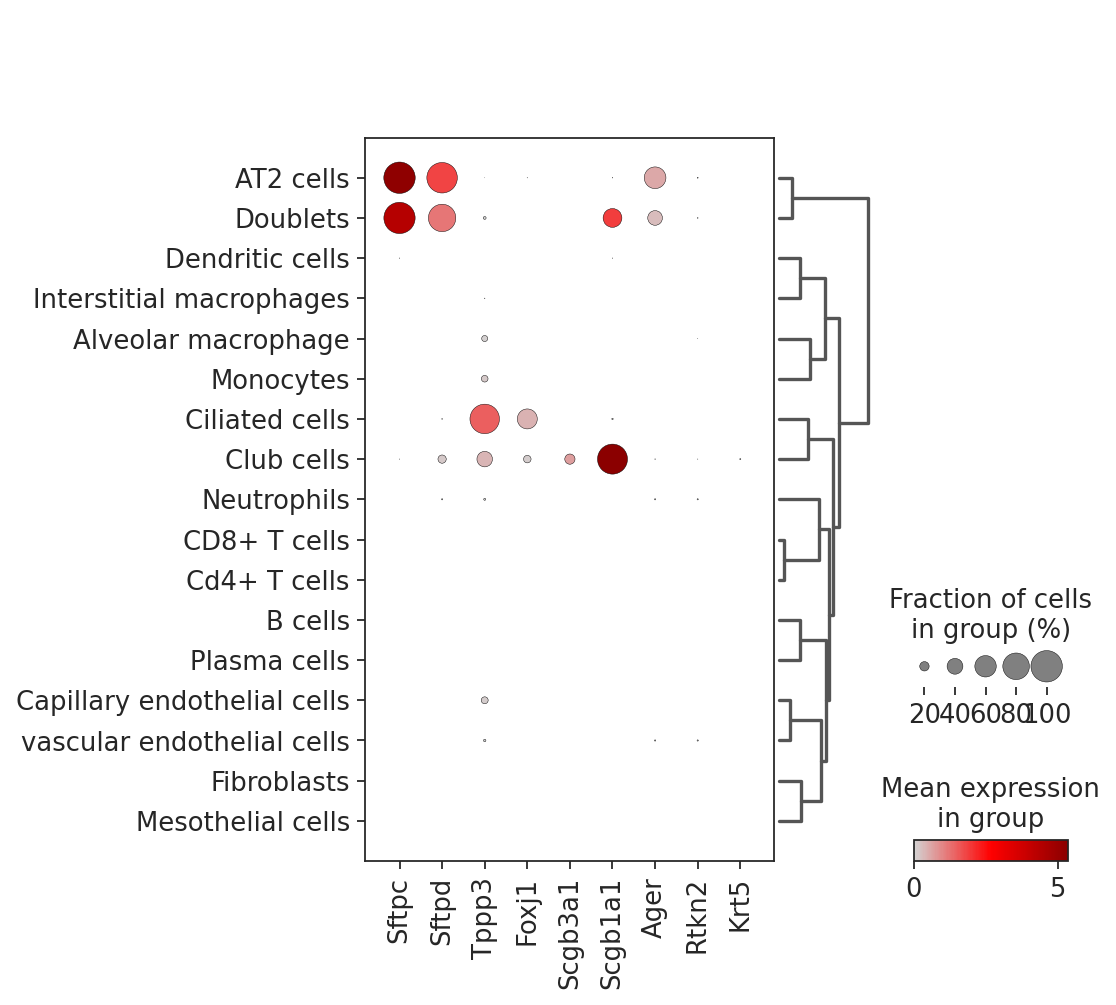

In [31]:
sc.pl.dotplot(adata, var_names = ["Sftpc", "Sftpd", "Tppp3", "Foxj1", "Scgb3a1", "Scgb1a1", "Ager", "Rtkn2", "Krt5"], 
              groupby = "cell_type", cmap = gray_red, dendrogram = True)

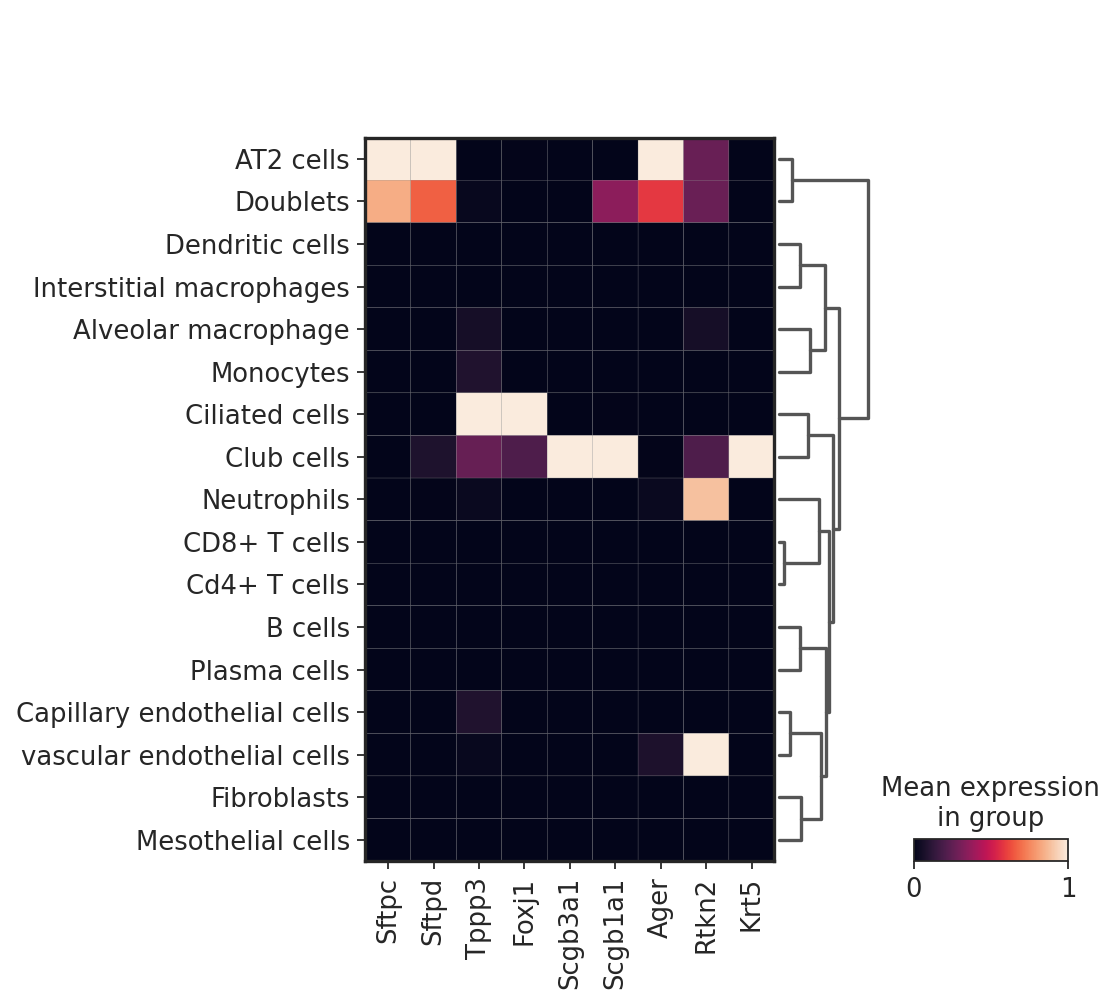

In [32]:
sc.pl.matrixplot(adata, groupby = "cell_type", cmap = "rocket", dendrogram = True, standard_scale = "var",
                 var_names = ["Sftpc", "Sftpd", "Tppp3", "Foxj1", "Scgb3a1", "Scgb1a1","Ager","Rtkn2","Krt5"])

### Re-cluster the object

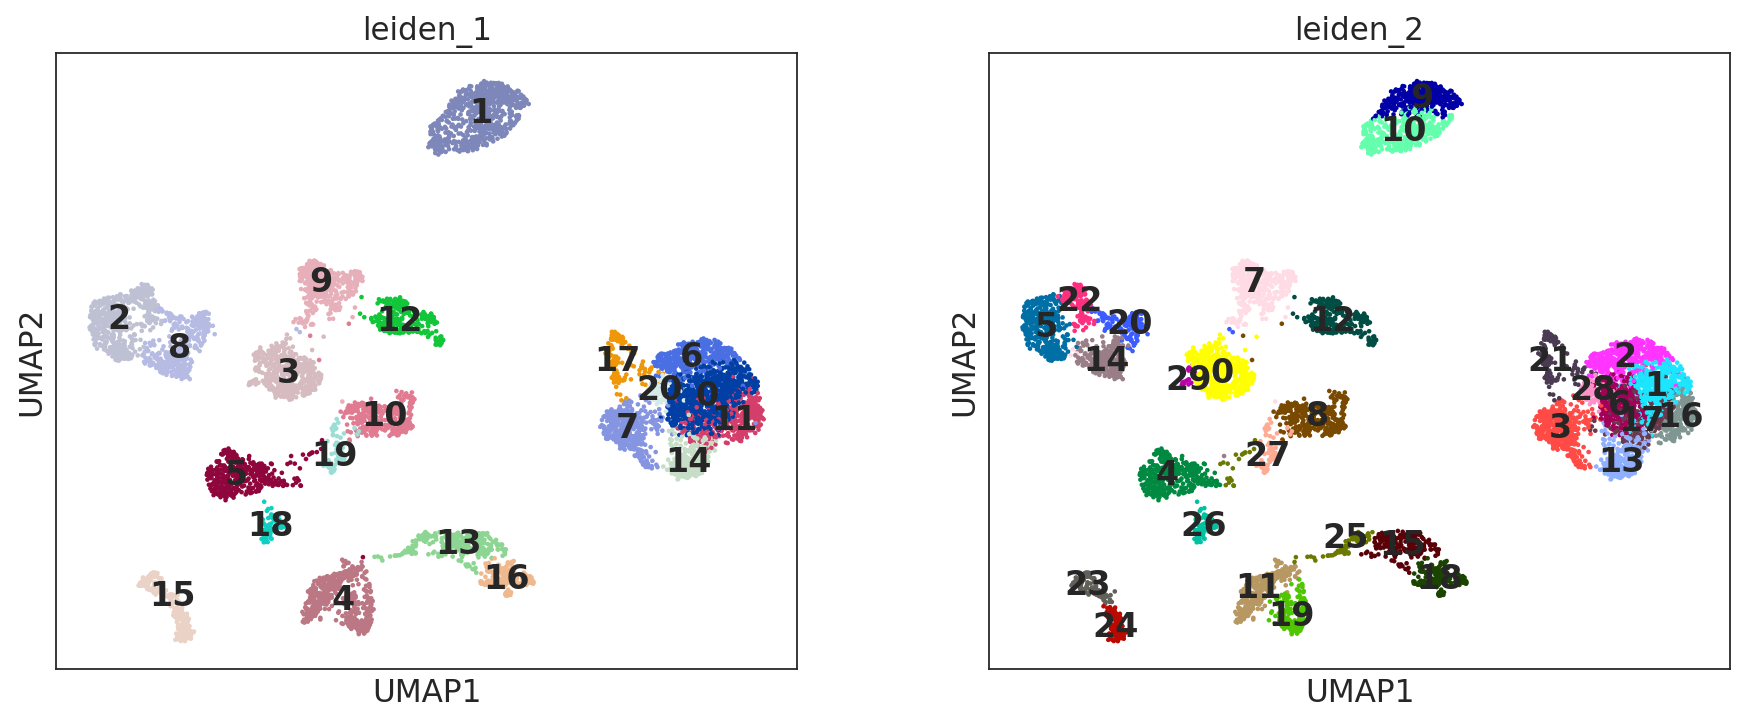

In [33]:
sc.tl.leiden(adata, resolution = 2, key_added = "leiden_2")
sc.pl.umap(adata, color = ["leiden_1", "leiden_2"], legend_loc = "on data", legend_fontsize = 15)

There are some subtypes of the endothelial compartment, which can not be easily resolved at this level
- General Capillary Marker: Edn1, Gpihbp1
- Lymphatic endothelial Marker: Prox1, Mmrn1, Maf

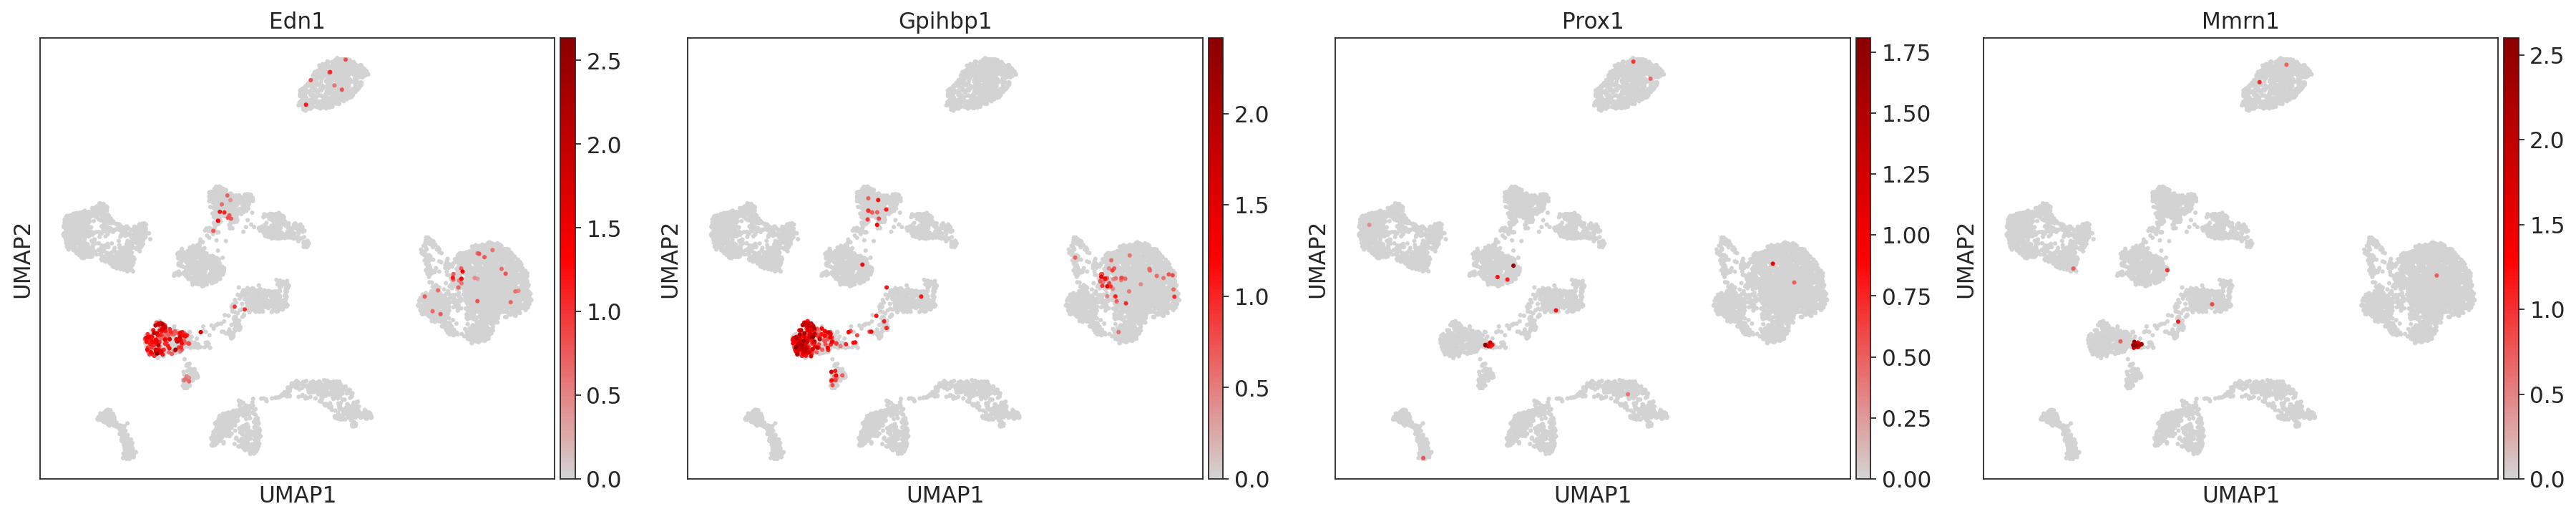

In [34]:
sc.pl.umap(adata, color = ["Edn1", "Gpihbp1", "Prox1", "Mmrn1"], cmap = gray_red, size = 30)

### Generate a subset

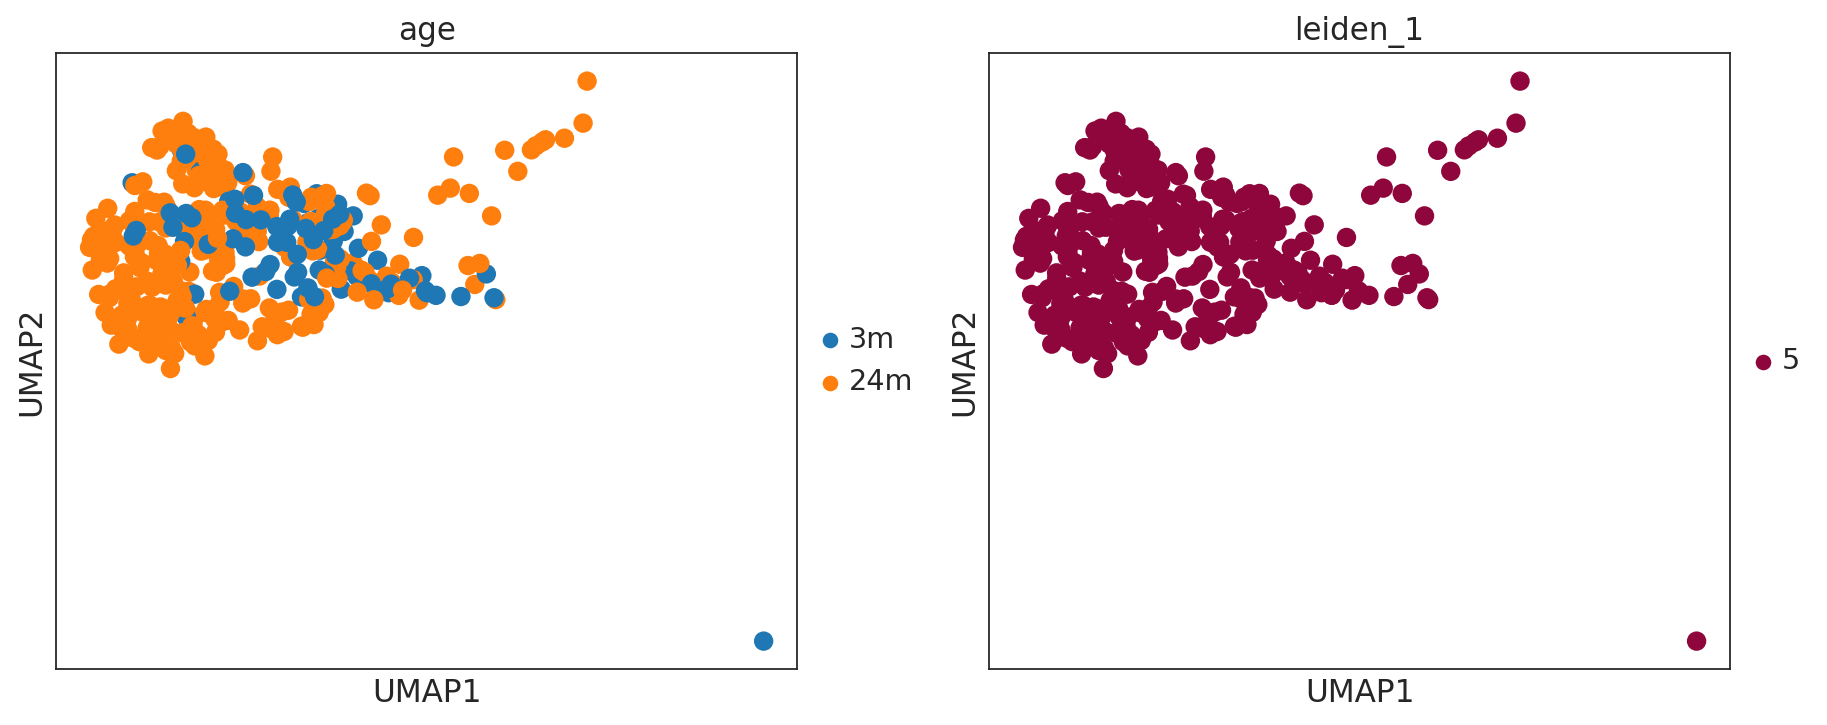

In [35]:
subset = adata[adata.obs.leiden_1.isin(["5"])].copy()
sc.pl.umap(subset, color = ["age", "leiden_1"])

We can highlight the heterogeneity in this subset by re-calculating the Principal components and the neighbourhood graph, to give more weight to genes that distinguish potential endothelial subtypes (rather than those that distinguish endothelial cells from other cell types in the lung)

In [36]:
## Recalculate PCA
sc.pp.pca(subset, n_comps = 50, use_highly_variable = True)

In [37]:
## Recalculate k nearest neighbor graph
## Here you can adjust the Parameters n_pcs (how many PCs are being used) n_neighbors (size of a cell’s neighborhood)
sc.pp.neighbors(subset, n_pcs = 10, n_neighbors = 10)
sc.tl.umap(subset)

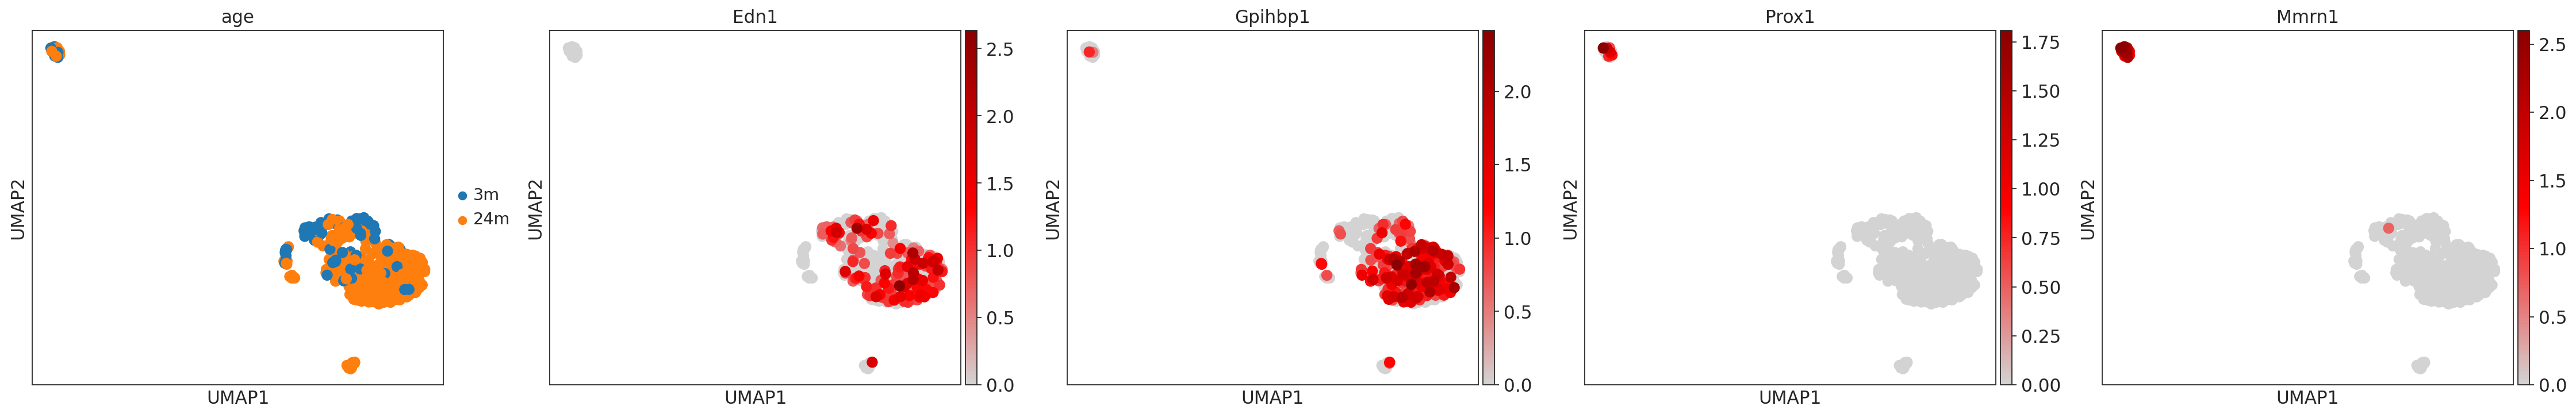

In [38]:
sc.pl.umap(subset, color = ["age", "Edn1", "Gpihbp1", "Prox1", "Mmrn1"], ncols = 5, cmap = gray_red)

You can then run a new clustering on this subset as well

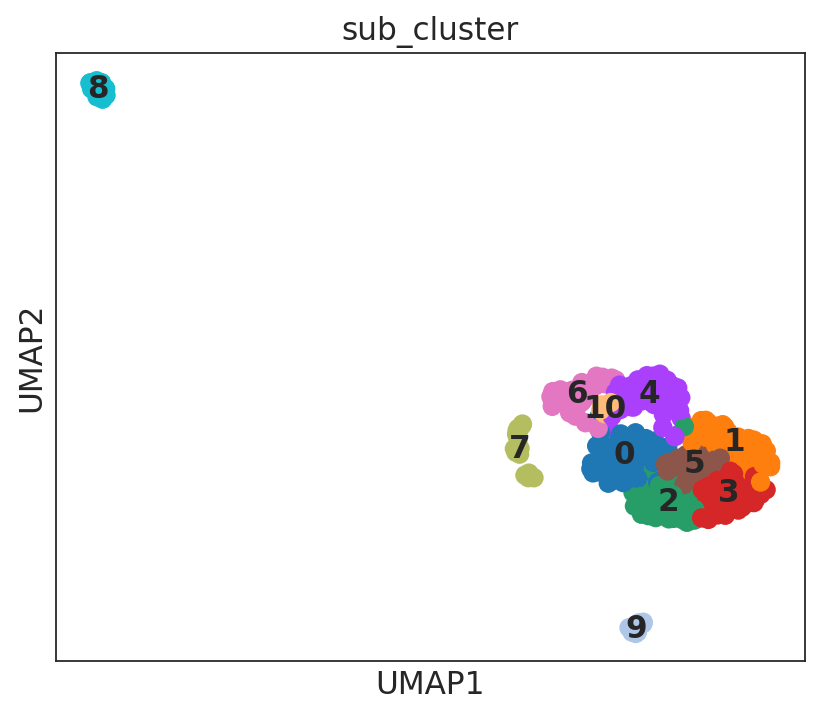

In [39]:
sc.tl.leiden(subset, resolution = 1, key_added = "sub_cluster")
sc.pl.umap(subset, color = ["sub_cluster"], legend_loc = "on data")

In [40]:
## you can even list more or less annotations in this dictionary
celltype_map = {"8": "Lymphatic EC", "2": "gCap", "3": "gCap", "5": "gCap", "1": "gCap", "0": "gCap",
                "6": "gCap", "10": "gCap", "4": "gCap", "7": "gCap", "9": "gCap"}

subset.obs["cell_type"] = [celltype_map[leiden] if leiden in celltype_map.keys() else leiden
                           for leiden in subset.obs.sub_cluster]

... storing 'cell_type' as categorical


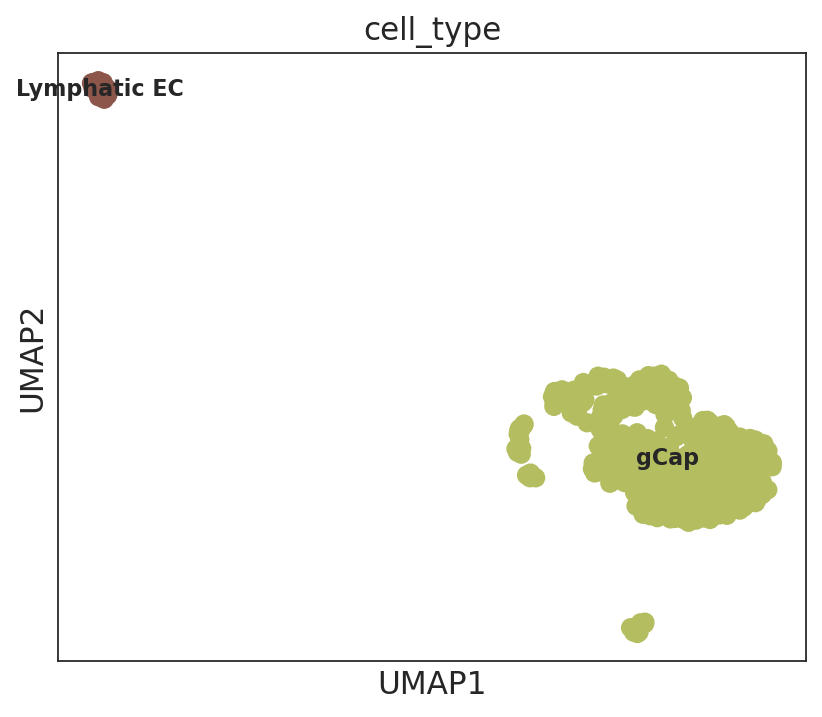

In [41]:
sc.pl.umap(subset, color = ["cell_type"], legend_loc = "on data", legend_fontsize = 10)

Transfer these more fine-grained labels back to the whole lung object

... storing 'cell_type' as categorical


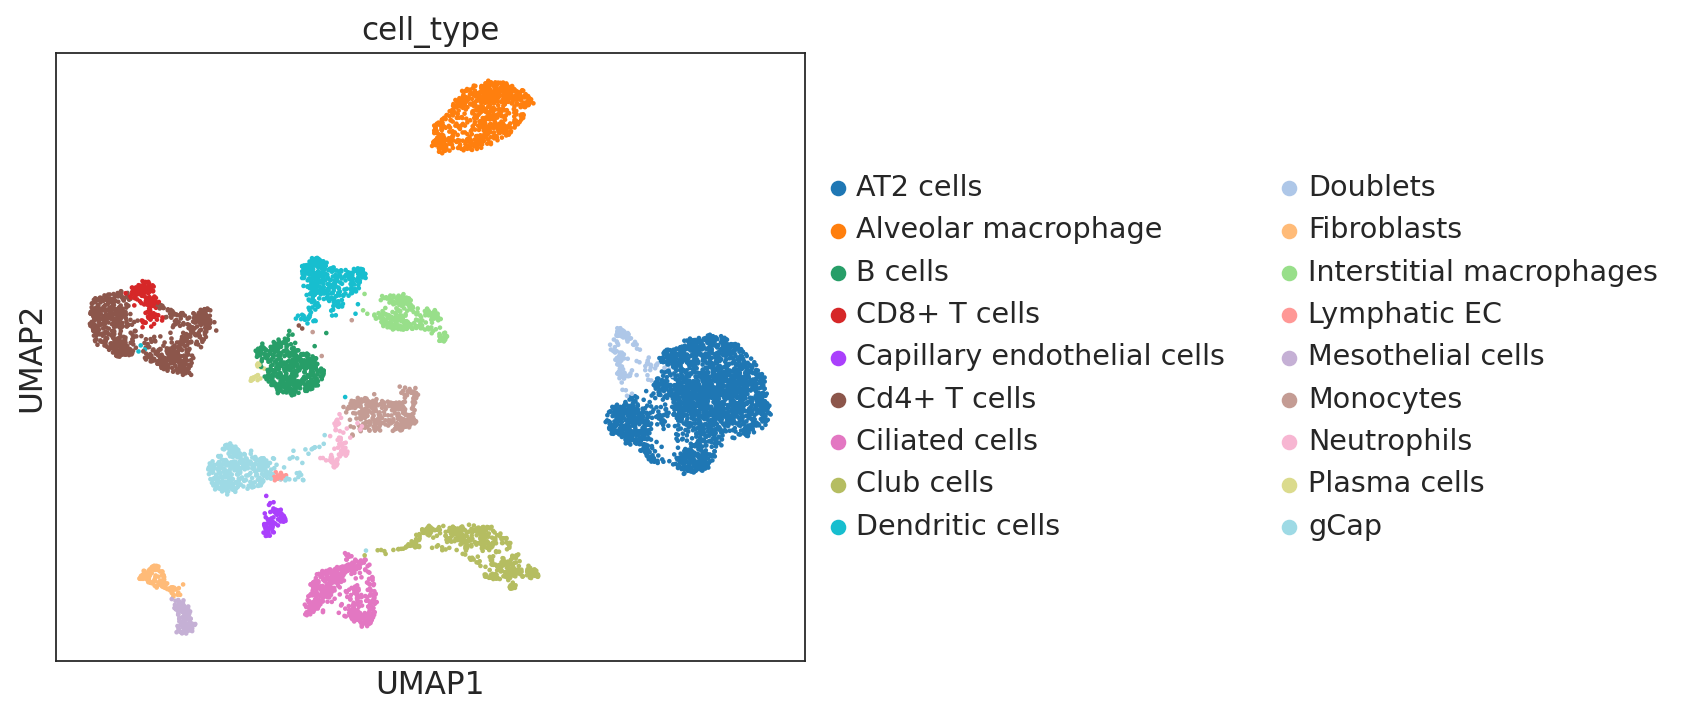

In [42]:
## This will only work if both the whole lung and subset column have the same name, here "cell_type"
adata.obs.update(subset.obs.cell_type)
sc.pl.umap(adata, color = ["cell_type"])

### Finally: save object

In [43]:
subset

AnnData object with n_obs × n_vars = 394 × 16959
    obs: 'batch', 'age', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'leiden_1', 'cell_type', 'leiden_2', 'sub_cluster'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_automated_colors', 'cell_type_colors', 'cell_type_final_colors', 'dendrogram_leiden_1', 'grouping_colors', 'hvg', 'identifier_colors', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'leiden_4_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'age_colors', 'dendrogram_cell_type', 'sub_cluster_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
subset.write("Data/endothelial_subset.h5ad")